In [1]:
# point to GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-f80e9374-504a-571b-bac0-6fb00750db4c"

In [2]:
import numpy as np
import pandas as pd
import torch
from collections import defaultdict
from scipy.spatial.distance import jensenshannon
from tqdm import tqdm
import gzip

import matplotlib.pyplot as plt

from utils import *

import sys
sys.path.append("../2_train_models")
from file_configs import FoldFilesConfig, MergedFilesConfig
from data_loading import extract_observed_profiles, extract_sequences, one_hot_encode

sys.path.append("../3_eval_models")
from eval_utils import model_predict_with_rc

sys.path.append("../figure_notebooks")
from load_annotations_utils import load_coords_with_summits
from common_functions import load_coords

from puffin import *

import logomaker

/users/kcochran/miniconda3/envs/puffin/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# specify what set of procapnet models to look at
cell_type = "K562"

# the unique IDs for each of the folds / models in this cell type
timestamps = ["2023-05-29_15-51-40",
              "2023-05-29_15-58-41",
              "2023-05-29_15-59-09",
              "2023-05-30_01-40-06",
              "2023-05-29_23-21-23",
              "2023-05-29_23-23-45",
              "2023-05-29_23-24-11"]

# these usually don't change
model_type = "strand_merged_umap"
data_type = "procap"

# size of the model inputs and outputs
in_window = 2114
out_window = 1000

In [4]:
# Load the config object for when model outputs were merged across all folds
# (just to pull some filepaths from)

merged_config = MergedFilesConfig(cell_type, model_type, data_type)

# these paths aren't specific to any model / fold, cell type, or data_type

proj_dir = merged_config.proj_dir
genome_path = merged_config.genome_path
chrom_sizes = merged_config.chrom_sizes

figures_dir = proj_dir + "figures/"
os.makedirs(figures_dir, exist_ok=True)

## Load Data, Models

In [60]:
# for ProCapNet, load in:
# 1) coordinates for all PRO-cap peaks in K562 (for plot annotation)
# 1) measured PRO-cap profiles in K562
# 2) predicted PRO-cap profiles + counts in K562

coords = load_coords(merged_config.all_peak_path, in_window=in_window)

K562_true_profs, _, _, K562_procapnet_pred_profs, K562_procapnet_pred_logcounts = load_procapnet_test_data(merged_config,
                                                                                                           timestamps)

Timestamp: 2023-05-29_15-51-40
Timestamp: 2023-05-29_15-58-41
Timestamp: 2023-05-29_15-59-09
Timestamp: 2023-05-30_01-40-06
Timestamp: 2023-05-29_23-21-23
Timestamp: 2023-05-29_23-23-45
Timestamp: 2023-05-29_23-24-11
== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 4334


Loading Profiles: 4334it [00:01, 4057.95it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 4334



Loading Profiles: 4334it [00:00, 4504.40it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 4334


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 3699


Loading Profiles: 3699it [00:00, 4486.81it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 3699



Loading Profiles: 3699it [00:00, 4507.30it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 3699


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 4559


Loading Profiles: 4559it [00:01, 4485.40it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 4559



Loading Profiles: 4559it [00:01, 4510.79it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 4559


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 3887


Loading Profiles: 3887it [00:00, 4511.55it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 3887



Loading Profiles: 3887it [00:00, 4515.42it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 3887


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 4470


Loading Profiles: 4470it [00:00, 4535.16it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 4470



Loading Profiles: 4470it [00:00, 4535.35it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 4470


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 5238


Loading Profiles: 5238it [00:01, 4522.34it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 5238



Loading Profiles: 5238it [00:01, 4511.86it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 5238


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 4347


Loading Profiles: 4347it [00:00, 4550.85it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 4347



Loading Profiles: 4347it [00:00, 4539.75it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 4347


Timestamp: 2023-05-29_15-51-40
Timestamp: 2023-05-29_15-58-41
Timestamp: 2023-05-29_15-59-09
Timestamp: 2023-05-30_01-40-06
Timestamp: 2023-05-29_23-21-23
Timestamp: 2023-05-29_23-23-45
Timestamp: 2023-05-29_23-24-11


### Load ProCapNet

In [7]:
# we'll just use the first-fold model for now

fold_config = FoldFilesConfig(cell_type, model_type, fold="1", timestamp = timestamps[0])
model_path = fold_config.model_save_path

procapnet = torch.load(model_path)
procapnet = procapnet.eval()
procapnet = procapnet.cuda()

Timestamp: 2023-05-29_15-51-40


### Load Puffin, Generate Predictions

In [8]:
# Load puffin model
puffin = Puffin(use_cuda=True)

In [9]:
def puffin_predict(genome_path, chrom_sizes, puffin_model, peak_path):
    # puffin's API wants sequences as strings, not numpy arrays
    # and to make 1kb prediction, it requires 1650bp of input sequence
    seqs = extract_sequences_not_ohe(genome_path, chrom_sizes,
                                     peak_path, in_window=1650)
    preds = []
    for seq in seqs:
        raw_pred_df = puffin_model.predict(seq)
        # select for the PRO-cap + and - strands from all outputs;
        # since Puffin's outputs are in natural-log-plus-one scale,
        # also convert to raw (aggregate dataset) counts scale
        pred = np.exp(np.array([np.array(raw_pred_df)[6],
                         np.array(raw_pred_df)[-1]]).astype(float)) - 1
        preds.append(pred)
        
    return np.array(preds) 

In [12]:
# generate puffin predictions at all K562 PRO-cap peaks

K562_puffin_pred_profs = puffin_predict(genome_path, chrom_sizes,
                                        puffin, merged_config.all_peak_path)

np.save("pred_profs_puffin_K562_peaks.npy", K562_puffin_pred_profs)

# to load back in if needed
#K562_puffin_pred_profs = np.load("pred_profs_puffin_K562_peaks.npy")

Loading genome sequence from /mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.fasta


Reading FASTA: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.10it/s]
Loading Peaks: 30534it [00:00, 30884.63it/s]


### Plot A Few Examples

In [14]:
random_loci = sorted(np.random.choice(range(K562_true_profs.shape[0]),
                                      size=200, replace=False))

168 ('chr1', 6419784, 6421898)
Read Count: 66.0


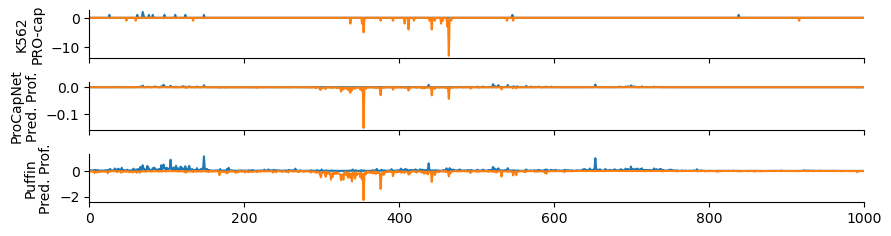

188 ('chr1', 6783928, 6786042)
Read Count: 1588.0


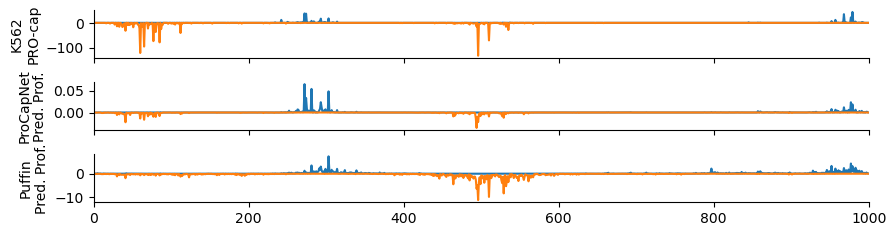

472 ('chr1', 20786320, 20788434)
Read Count: 2085.0


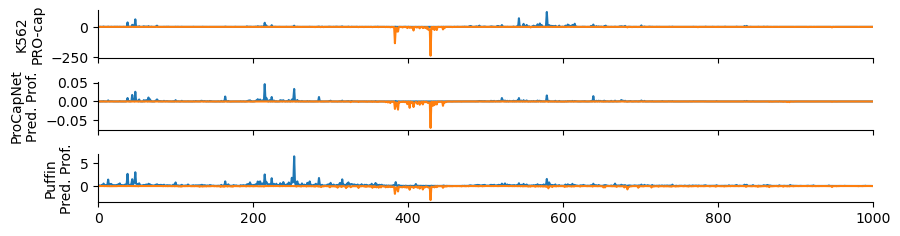

505 ('chr1', 22024901, 22027015)
Read Count: 1928.0


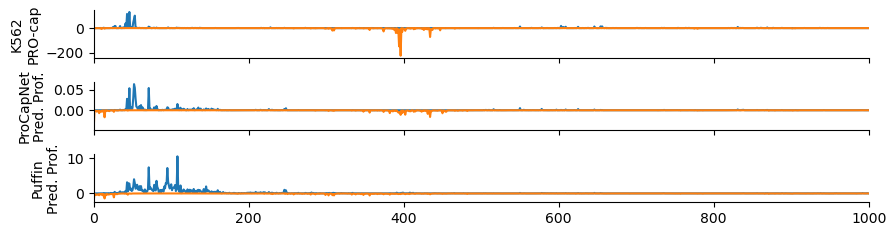

767 ('chr1', 28735369, 28737483)
Read Count: 720.0


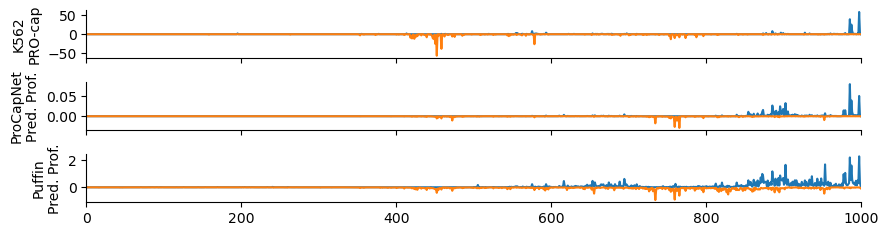

1036 ('chr1', 39638693, 39640807)
Read Count: 224.0


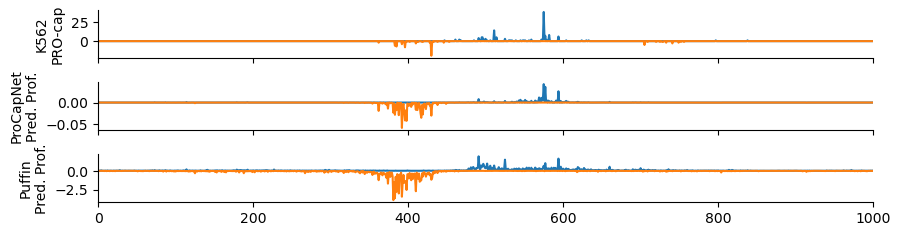

1121 ('chr1', 43990605, 43992719)
Read Count: 576.0


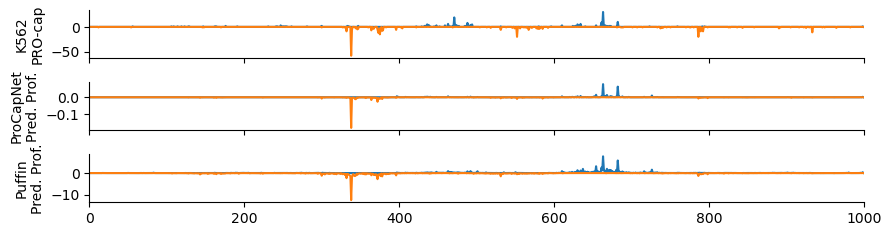

1293 ('chr1', 53325229, 53327343)
Read Count: 1991.0


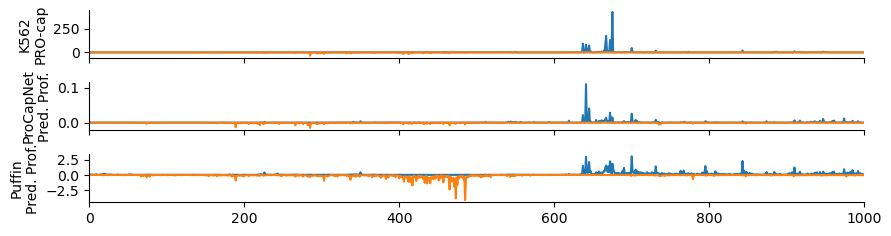

1620 ('chr1', 99767601, 99769715)
Read Count: 130.0


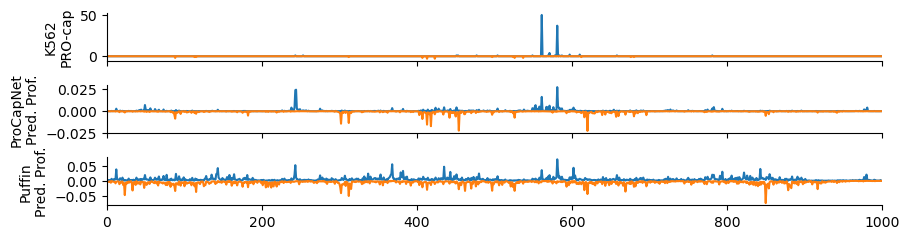

2063 ('chr1', 151458447, 151460561)
Read Count: 909.0


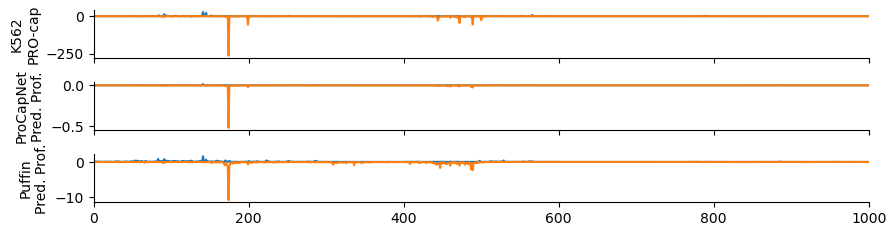

2074 ('chr1', 151908791, 151910905)
Read Count: 2598.0


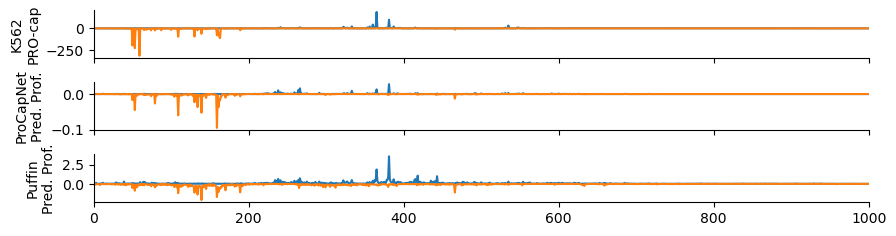

2117 ('chr1', 153976242, 153978356)
Read Count: 2995.0


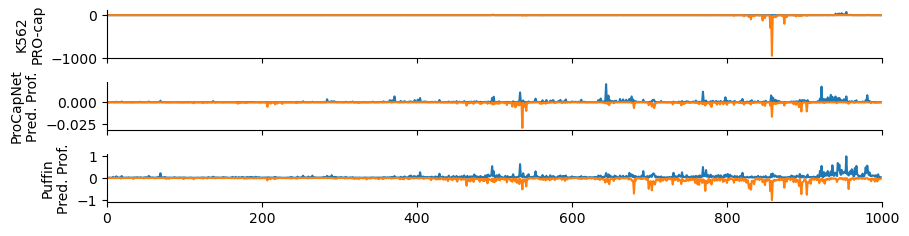

2128 ('chr1', 154219196, 154221310)
Read Count: 841.0


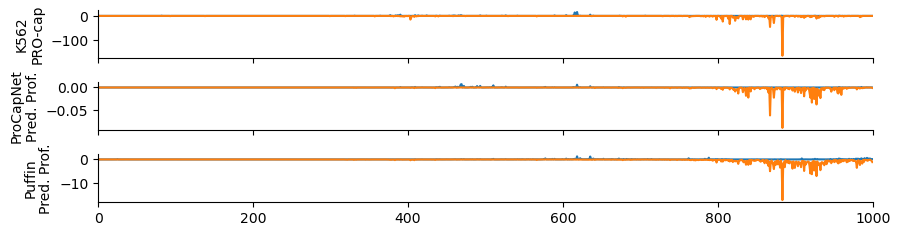

2403 ('chr1', 167539474, 167541588)
Read Count: 67.0


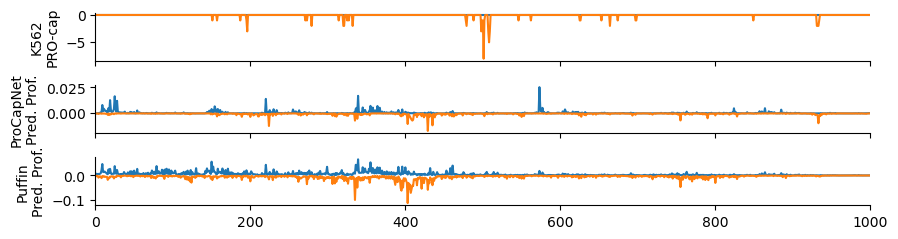

2551 ('chr1', 180514947, 180517061)
Read Count: 28.0


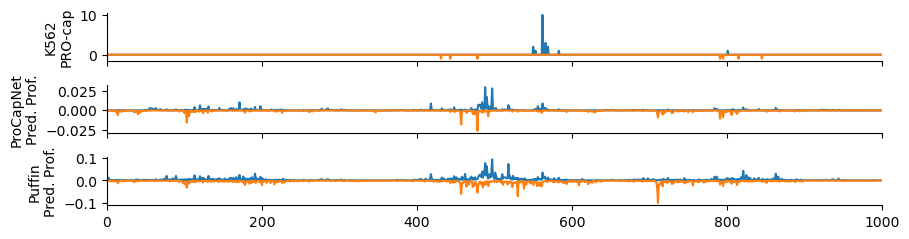

2552 ('chr1', 180541705, 180543819)
Read Count: 29.0


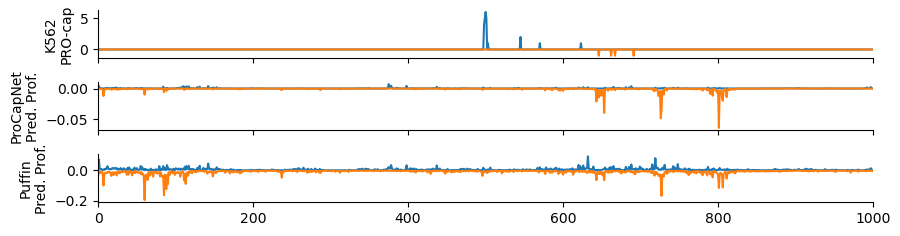

2862 ('chr1', 211606014, 211608128)
Read Count: 913.0


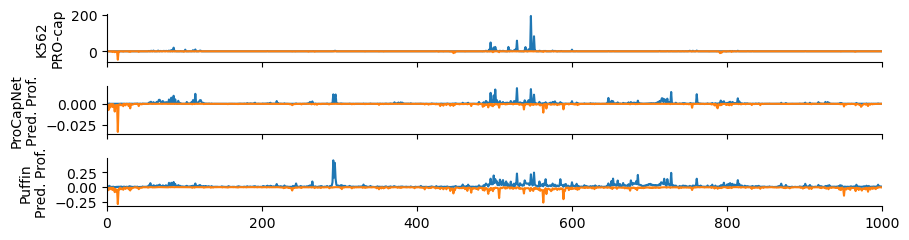

3010 ('chr1', 226308242, 226310356)
Read Count: 2032.0


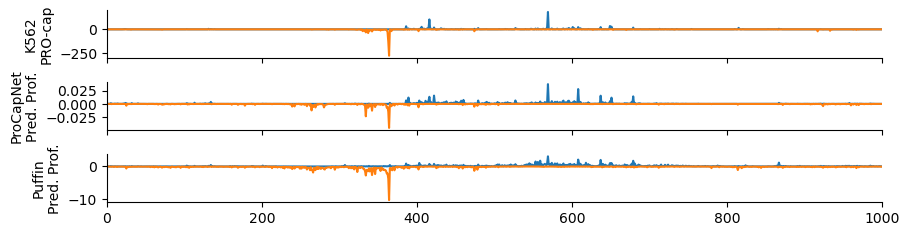

3042 ('chr1', 228165011, 228167125)
Read Count: 4351.0


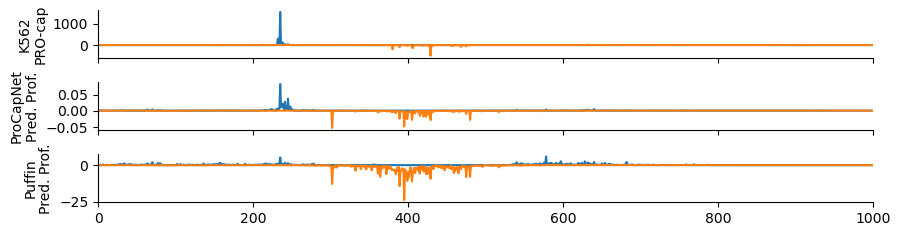

3048 ('chr1', 228368296, 228370410)
Read Count: 251.0


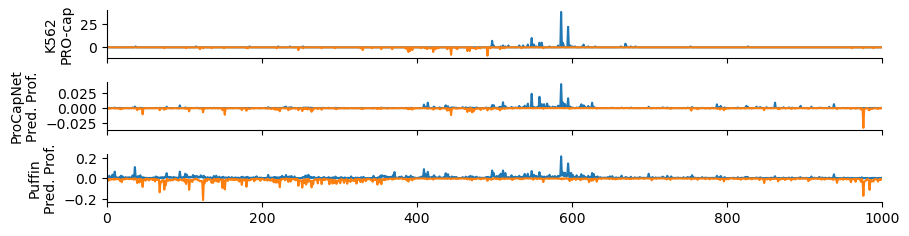

3093 ('chr1', 232804336, 232806450)
Read Count: 206.0


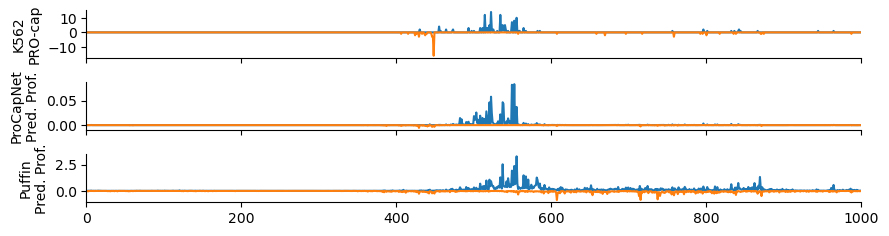

3297 ('chr10', 3094500, 3096614)
Read Count: 154.0


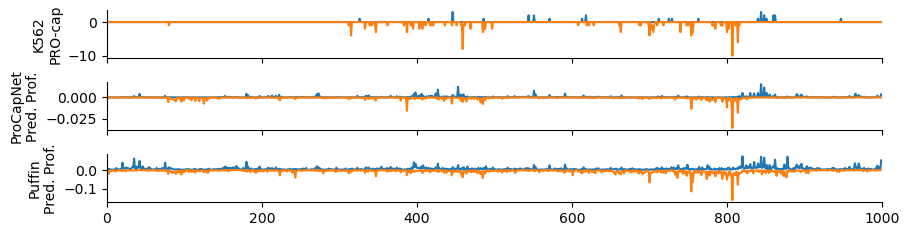

3385 ('chr10', 11611596, 11613710)
Read Count: 146.0


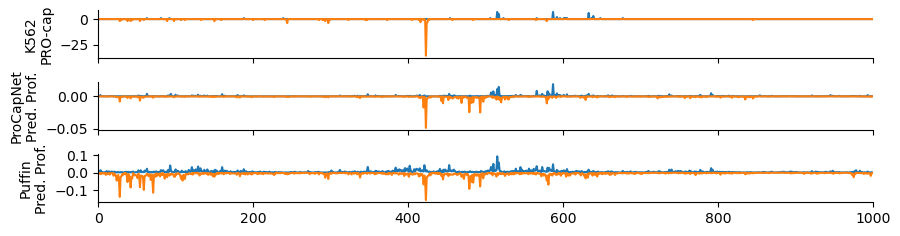

3701 ('chr10', 46105589, 46107703)
Read Count: 185.0


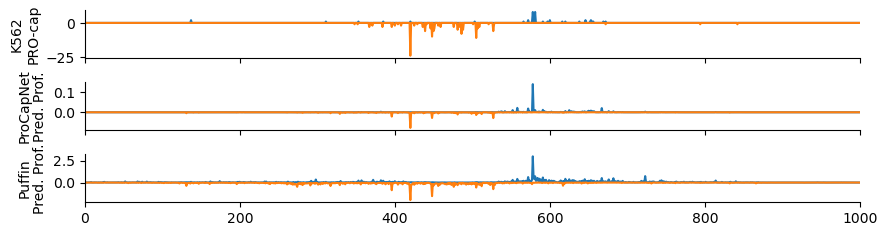

3768 ('chr10', 58266918, 58269032)
Read Count: 1479.0


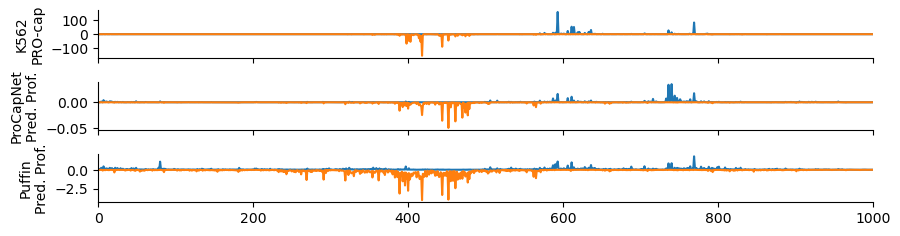

3923 ('chr10', 71887681, 71889795)
Read Count: 487.0


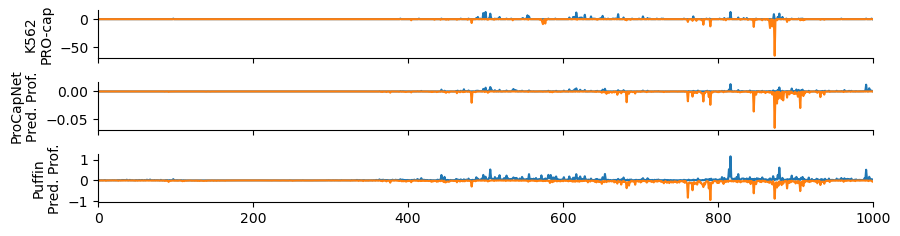

4345 ('chr10', 103966032, 103968146)
Read Count: 1107.0


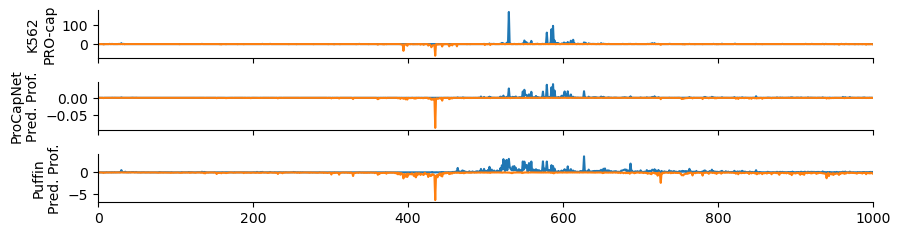

4364 ('chr10', 110207557, 110209671)
Read Count: 141.0


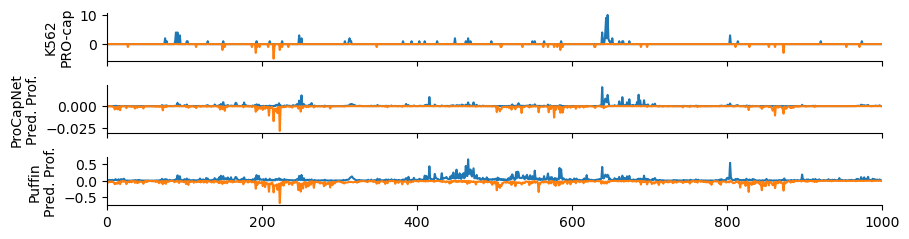

4724 ('chr11', 6689835, 6691949)
Read Count: 65.0


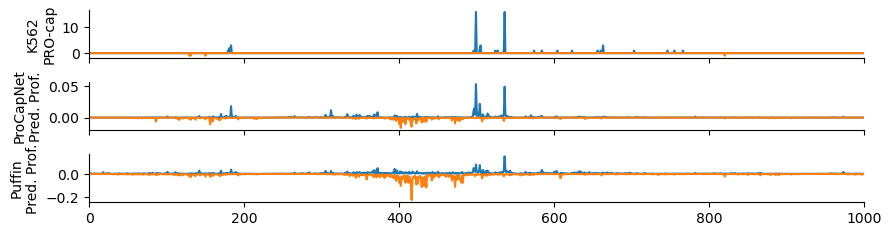

5018 ('chr11', 45884588, 45886702)
Read Count: 34.0


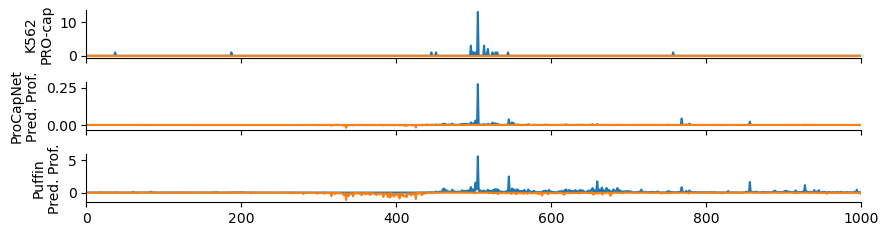

5076 ('chr11', 47268559, 47270673)
Read Count: 1879.0


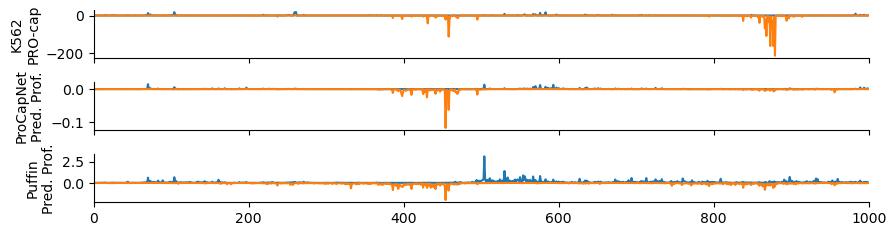

5088 ('chr11', 47564527, 47566641)
Read Count: 1446.0


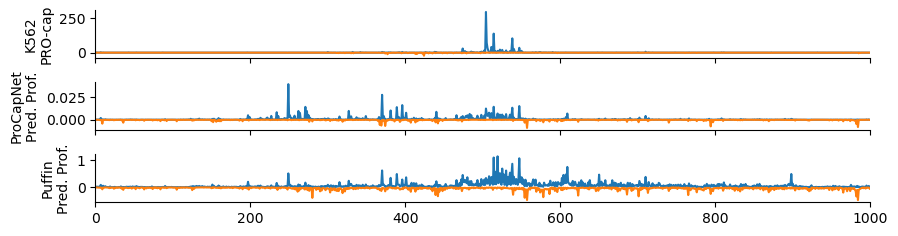

5240 ('chr11', 62611745, 62613859)
Read Count: 588.0


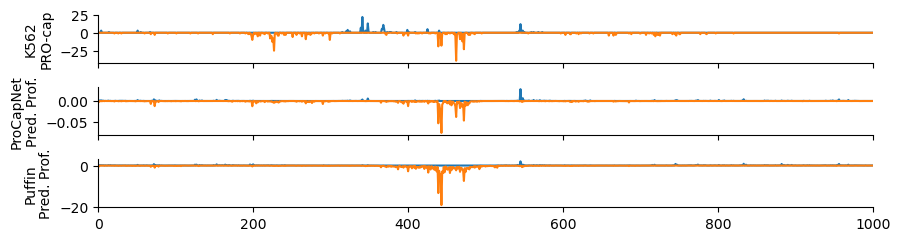

5421 ('chr11', 65380915, 65383029)
Read Count: 309.0


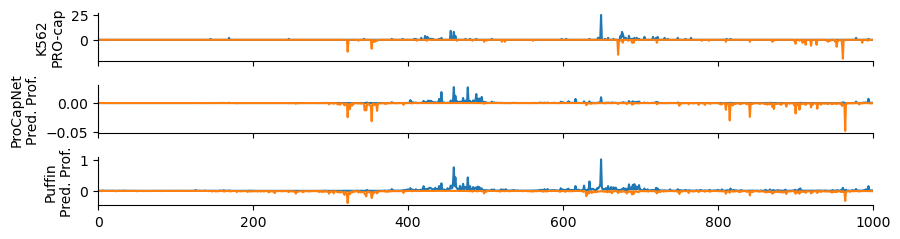

5876 ('chr11', 86742482, 86744596)
Read Count: 91.0


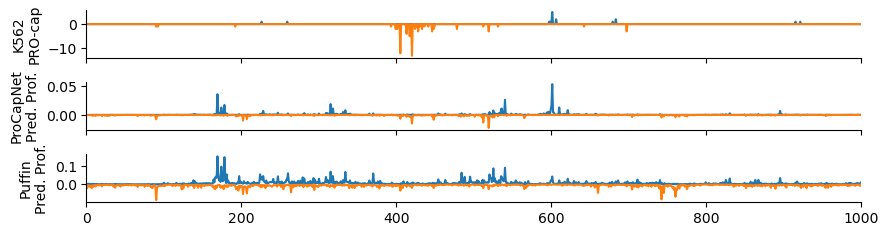

6053 ('chr11', 118571337, 118573451)
Read Count: 851.0


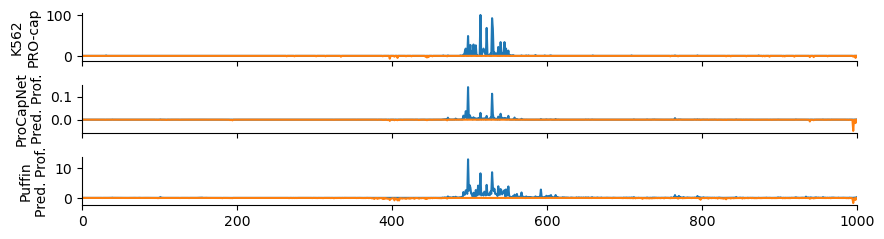

6135 ('chr11', 123061491, 123063605)
Read Count: 1988.0


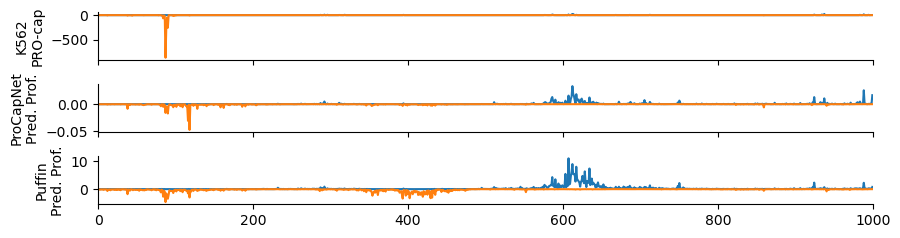

6390 ('chr12', 10212311, 10214425)
Read Count: 340.0


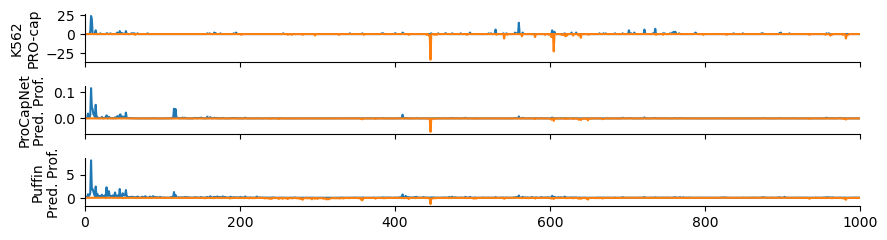

6404 ('chr12', 11648709, 11650823)
Read Count: 538.0


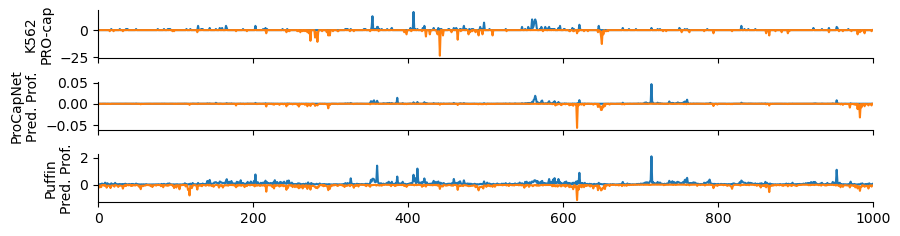

6581 ('chr12', 42236579, 42238693)
Read Count: 694.0


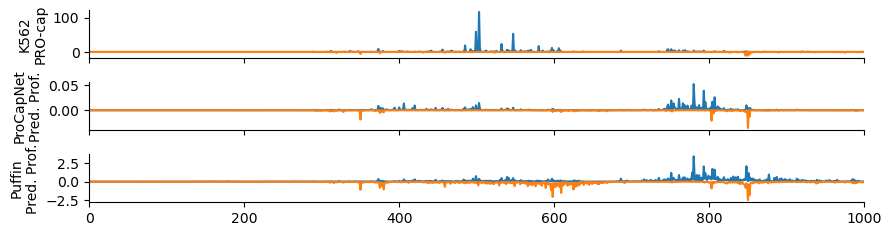

6955 ('chr12', 56257373, 56259487)
Read Count: 1021.0


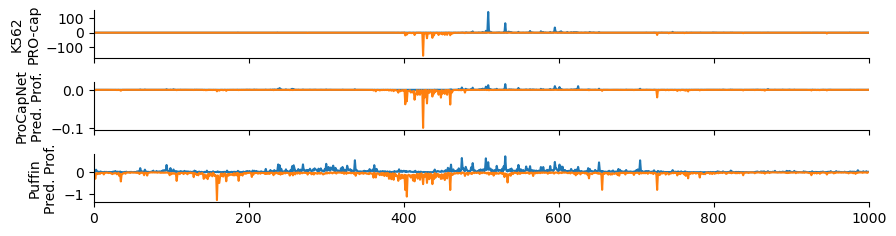

7103 ('chr12', 67268550, 67270664)
Read Count: 1091.0


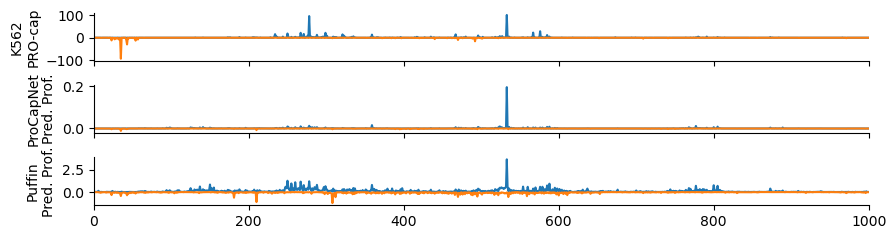

7149 ('chr12', 74170172, 74172286)
Read Count: 529.0


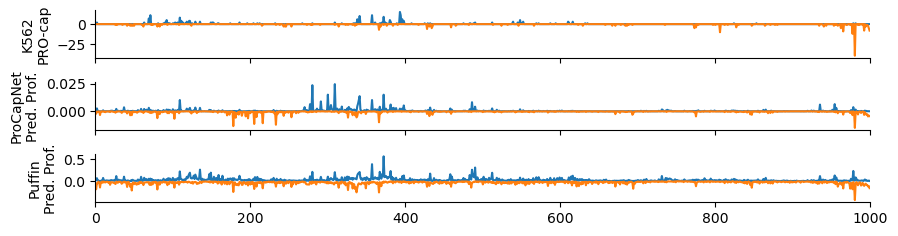

7582 ('chr12', 121800002, 121802116)
Read Count: 1235.0


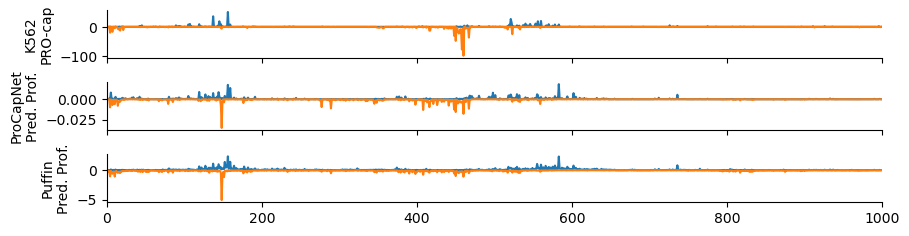

7587 ('chr12', 121803741, 121805855)
Read Count: 135.0


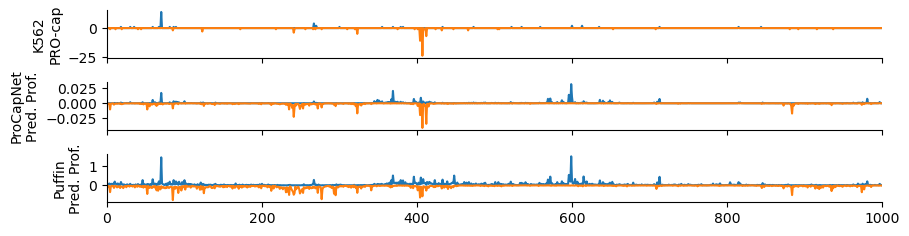

7646 ('chr12', 123388835, 123390949)
Read Count: 167.0


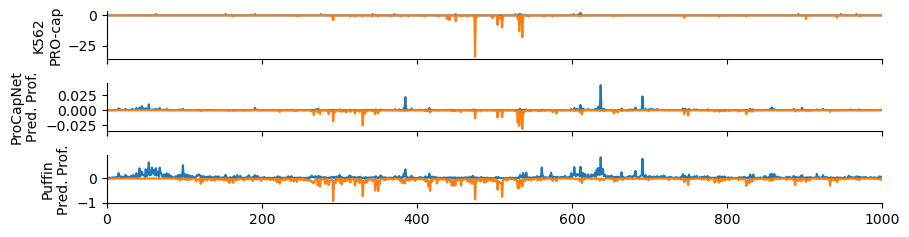

7754 ('chr13', 19632527, 19634641)
Read Count: 382.0


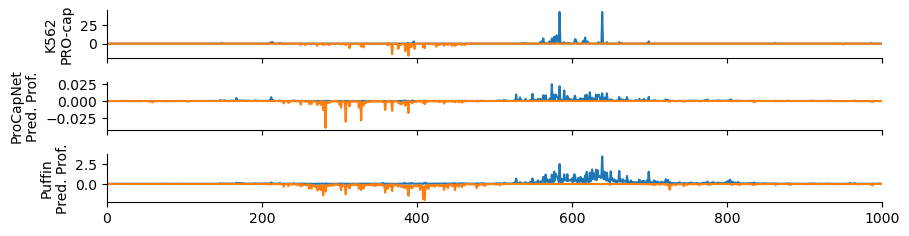

7902 ('chr13', 44258171, 44260285)
Read Count: 65.0


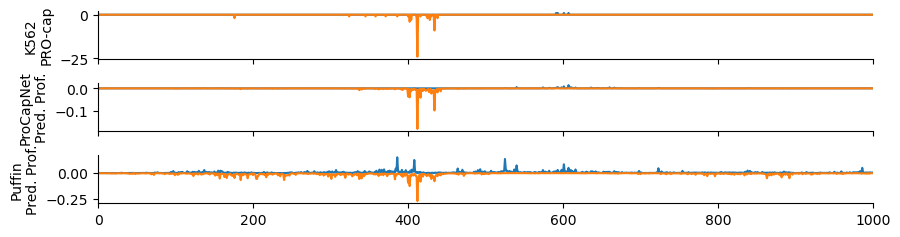

8348 ('chr14', 24212457, 24214571)
Read Count: 919.0


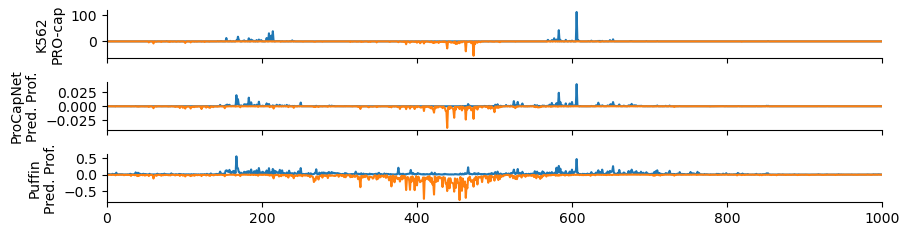

8438 ('chr14', 36319644, 36321758)
Read Count: 349.0


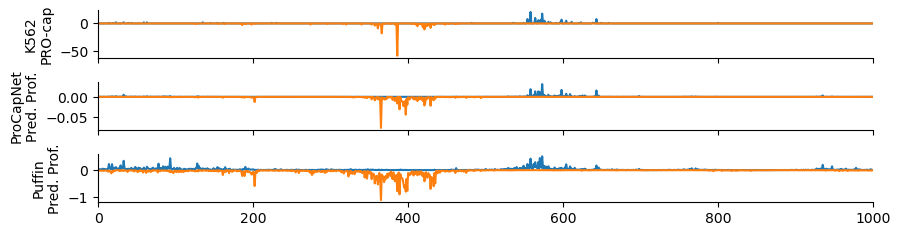

8832 ('chr14', 88823473, 88825587)
Read Count: 449.0


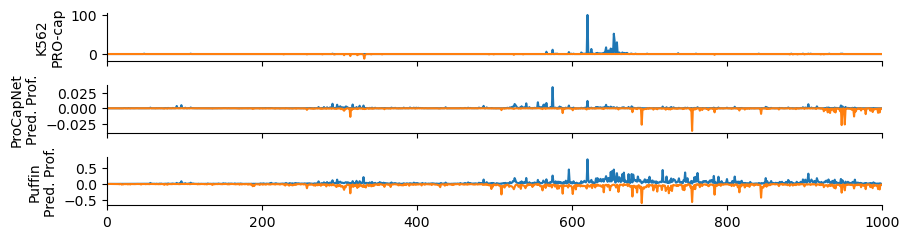

8885 ('chr14', 95156123, 95158237)
Read Count: 335.0


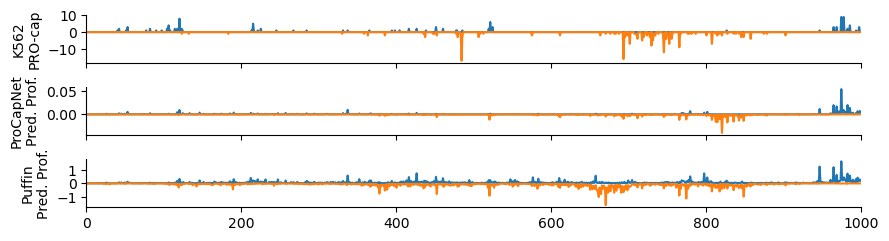

8894 ('chr14', 96390694, 96392808)
Read Count: 295.0


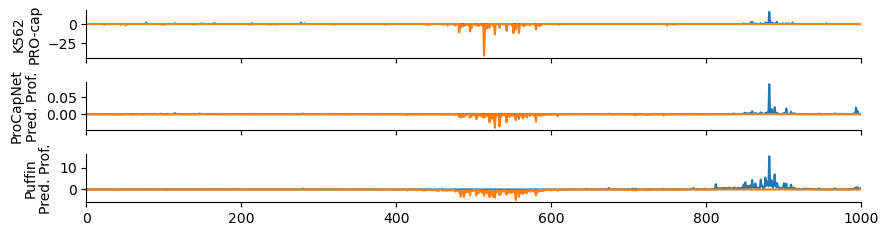

8908 ('chr14', 100067630, 100069744)
Read Count: 101.0


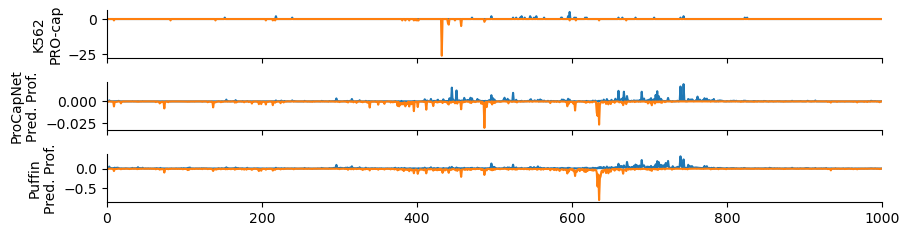

9639 ('chr15', 74540021, 74542135)
Read Count: 1159.0


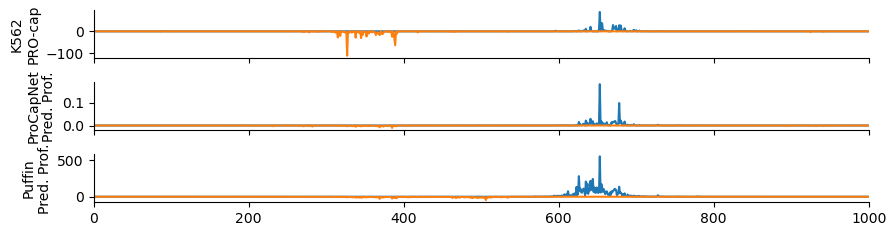

9689 ('chr15', 75711775, 75713889)
Read Count: 23.0


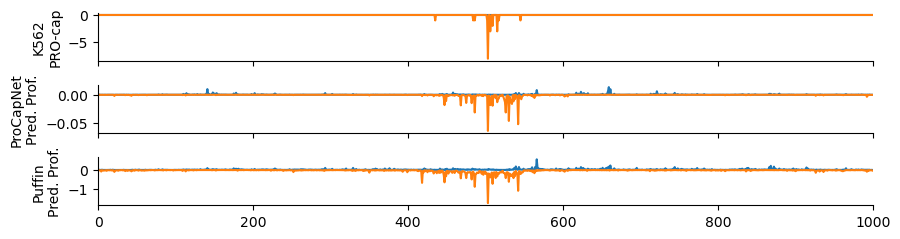

9790 ('chr15', 82749098, 82751212)
Read Count: 2051.0


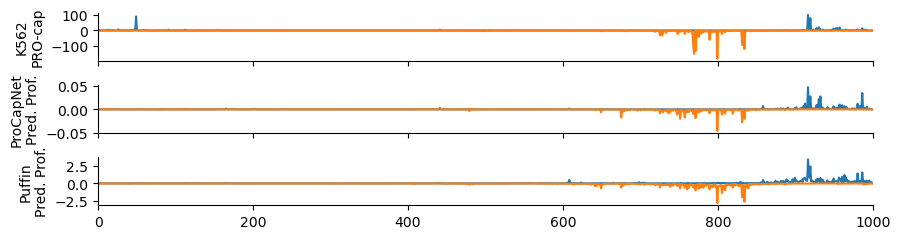

9803 ('chr15', 83106561, 83108675)
Read Count: 143.0


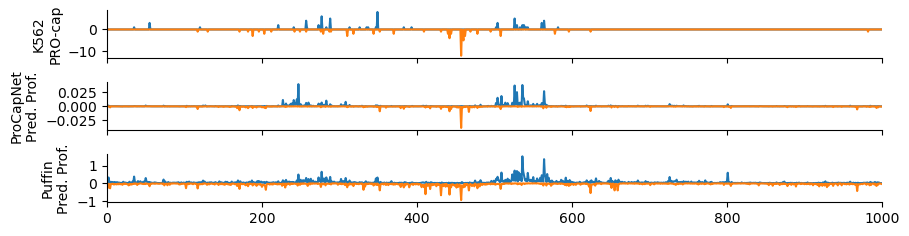

9982 ('chr15', 101250430, 101252544)
Read Count: 369.0


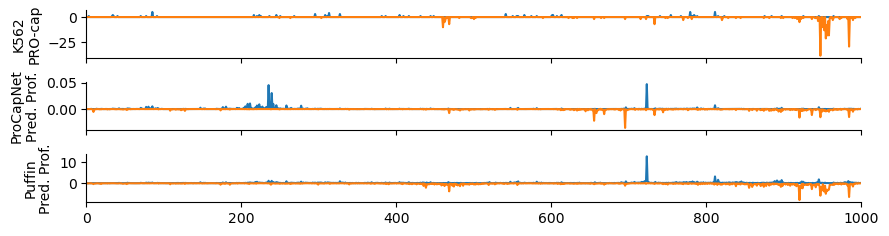

10039 ('chr16', 621368, 623482)
Read Count: 332.0


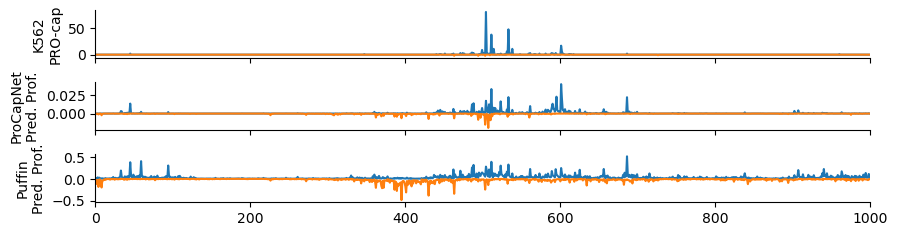

10104 ('chr16', 1942277, 1944391)
Read Count: 1104.0


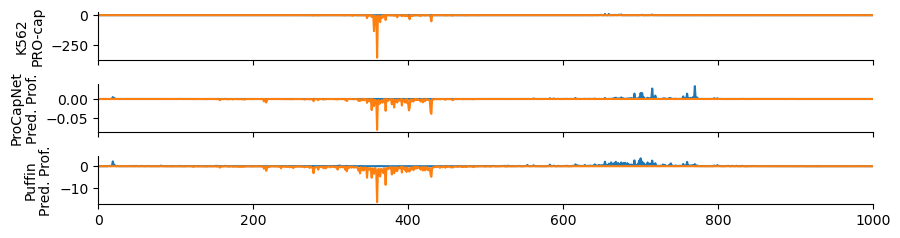

10148 ('chr16', 2427491, 2429605)
Read Count: 362.0


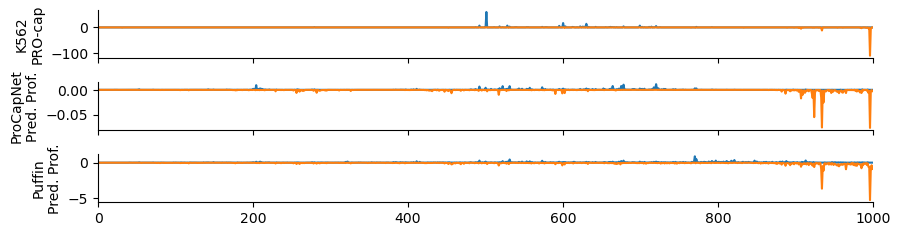

10199 ('chr16', 3027270, 3029384)
Read Count: 108.0


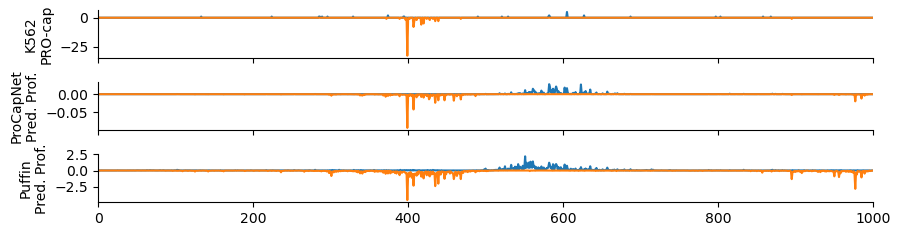

10398 ('chr16', 19113157, 19115271)
Read Count: 483.0


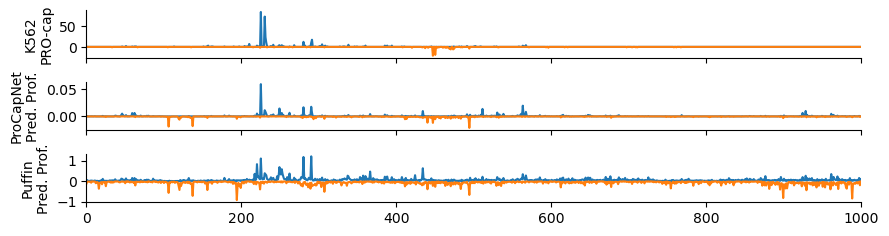

11086 ('chr16', 83898505, 83900619)
Read Count: 337.0


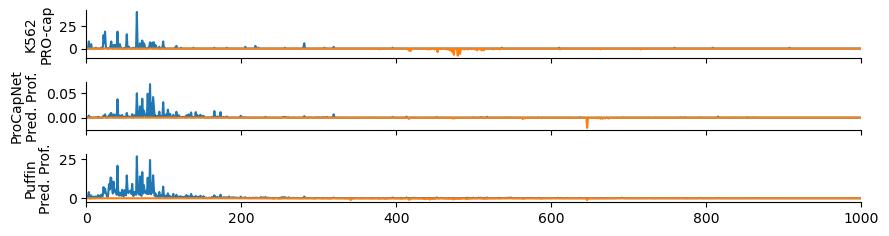

11368 ('chr17', 4262316, 4264430)
Read Count: 113.0


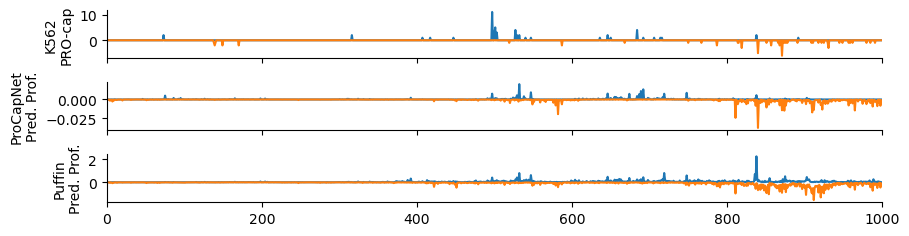

11412 ('chr17', 6574382, 6576496)
Read Count: 163.0


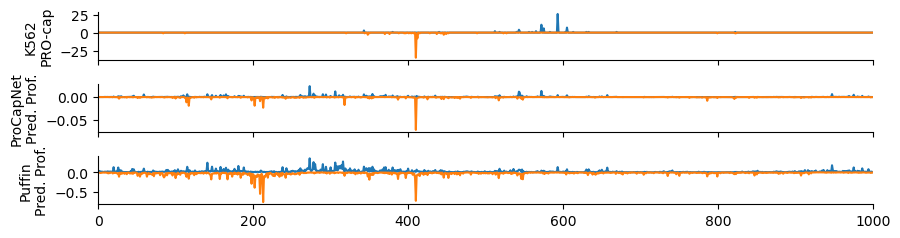

11437 ('chr17', 7306393, 7308507)
Read Count: 1304.0


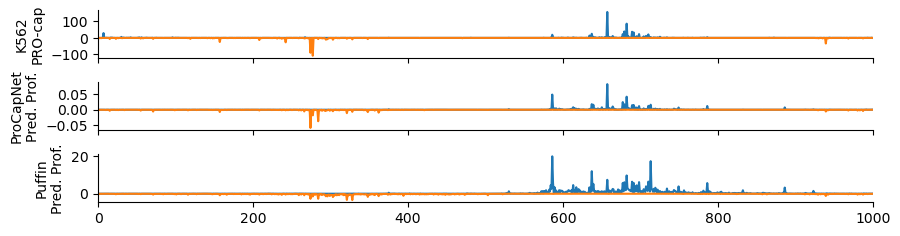

11610 ('chr17', 17782332, 17784446)
Read Count: 128.0


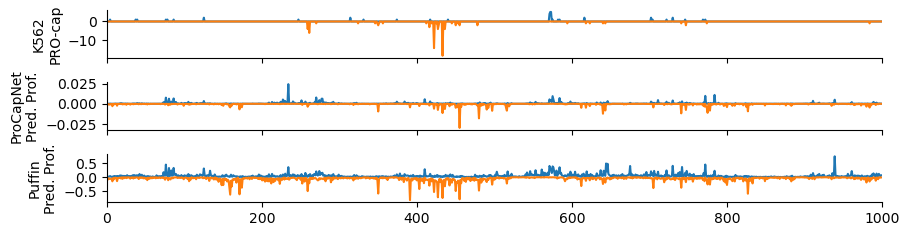

11772 ('chr17', 29139377, 29141491)
Read Count: 85.0


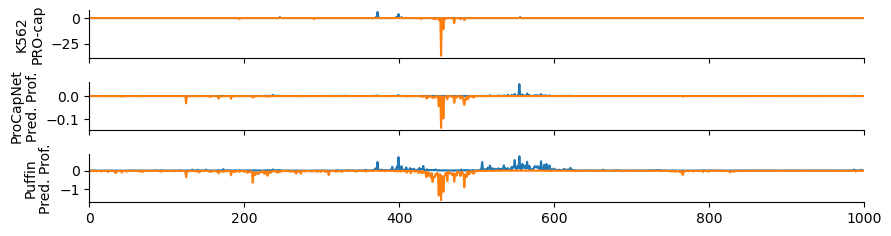

11876 ('chr17', 35539836, 35541950)
Read Count: 77.0


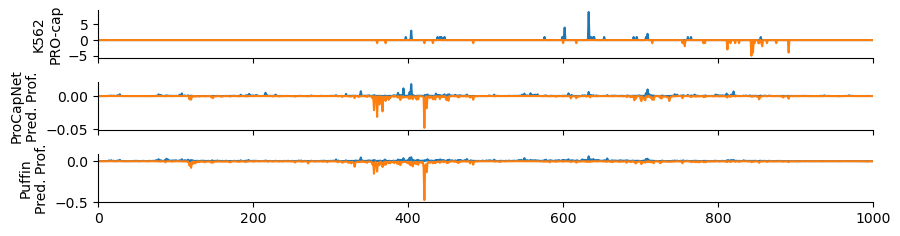

11999 ('chr17', 40139293, 40141407)
Read Count: 1270.0


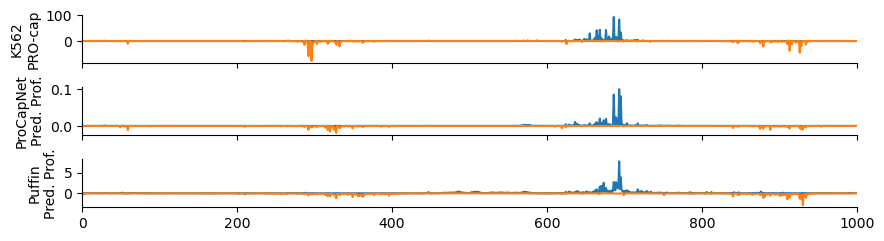

12237 ('chr17', 45404504, 45406618)
Read Count: 41.0


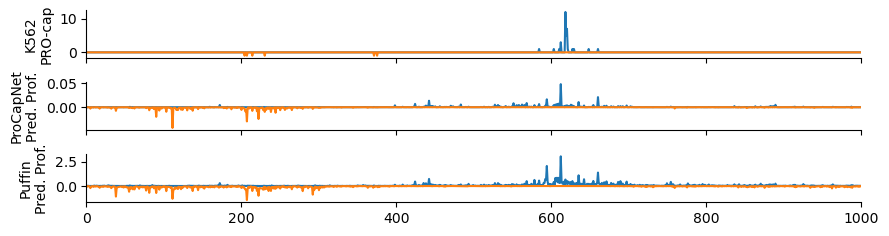

12263 ('chr17', 46921948, 46924062)
Read Count: 1453.0


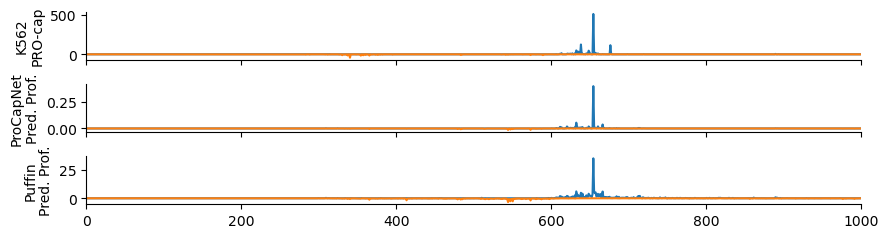

12324 ('chr17', 48577403, 48579517)
Read Count: 815.0


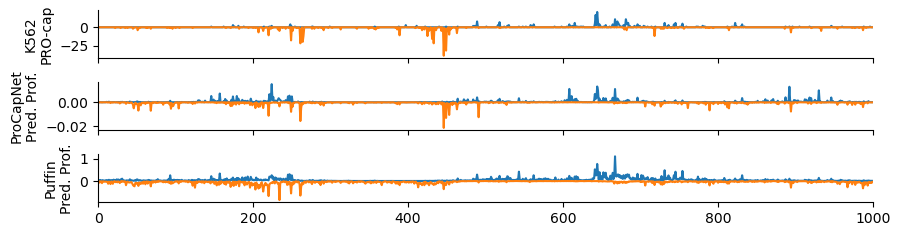

12344 ('chr17', 48630279, 48632393)
Read Count: 239.0


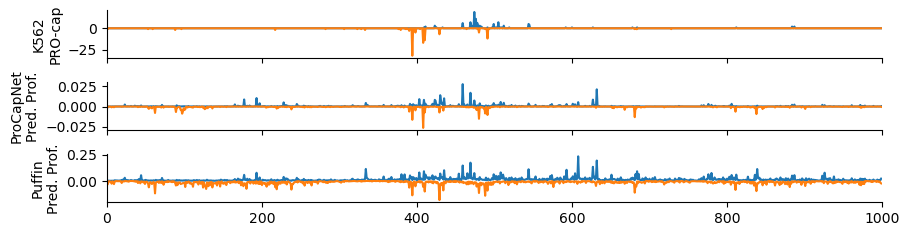

12621 ('chr17', 66295323, 66297437)
Read Count: 91.0


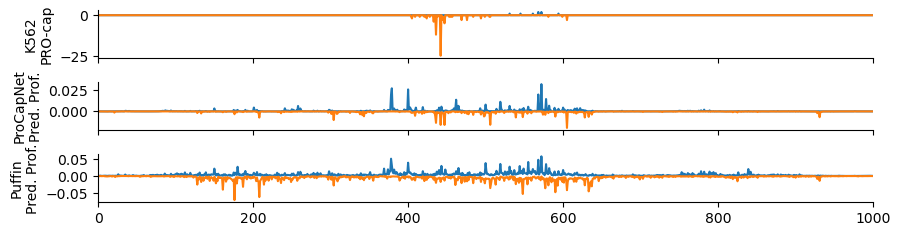

12749 ('chr17', 75895492, 75897606)
Read Count: 1886.0


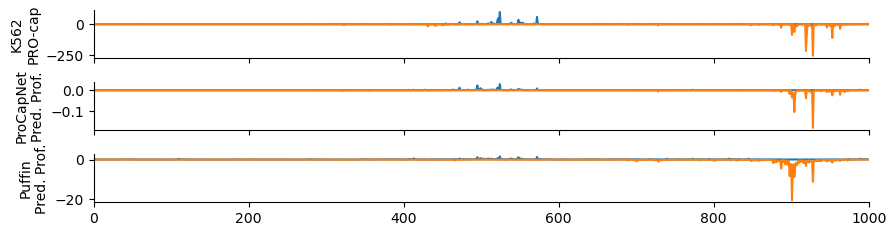

12922 ('chr17', 81364761, 81366875)
Read Count: 184.0


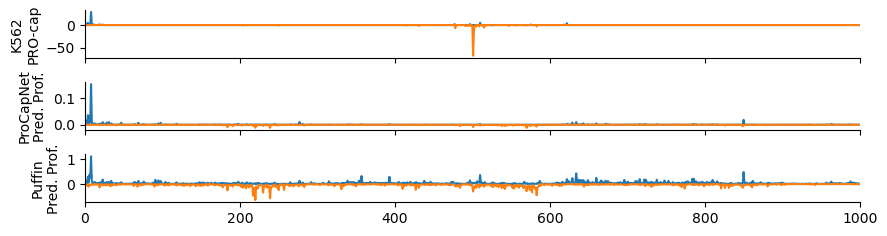

12966 ('chr17', 81831907, 81834021)
Read Count: 890.0


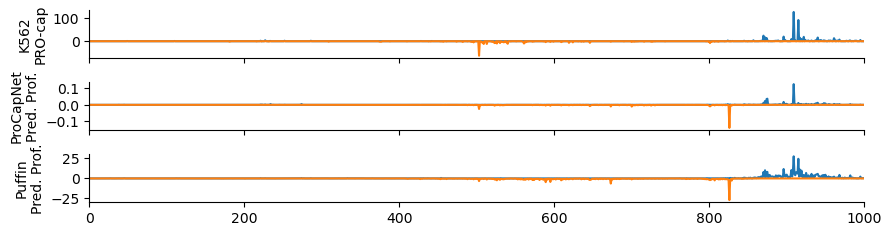

12994 ('chr17', 81976869, 81978983)
Read Count: 2231.0


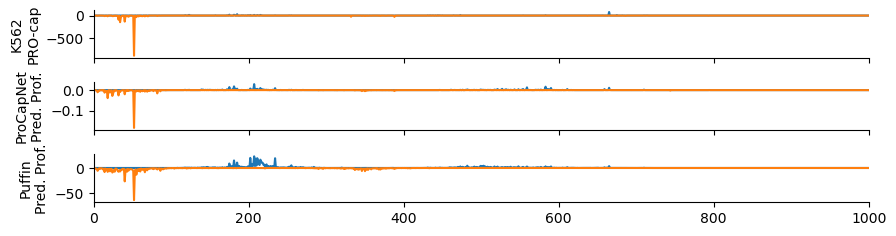

13313 ('chr18', 35971532, 35973646)
Read Count: 1603.0


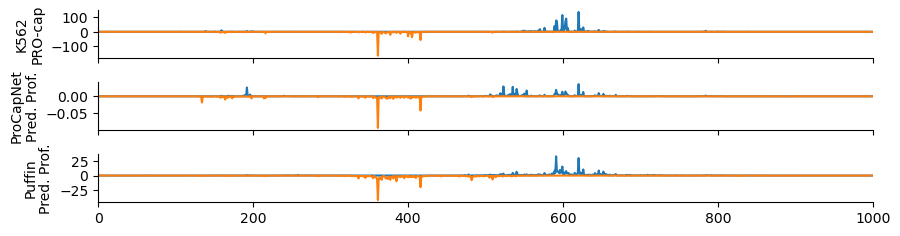

13427 ('chr18', 63366238, 63368352)
Read Count: 1601.0


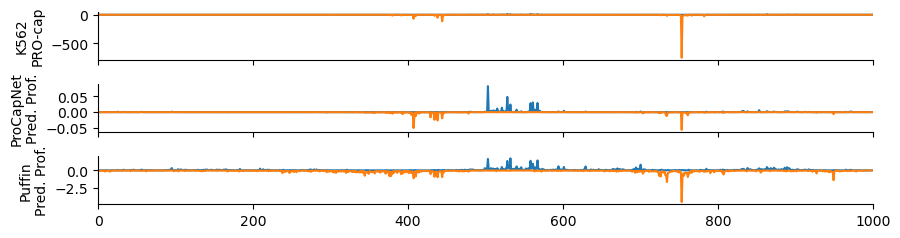

13521 ('chr19', 790598, 792712)
Read Count: 529.0


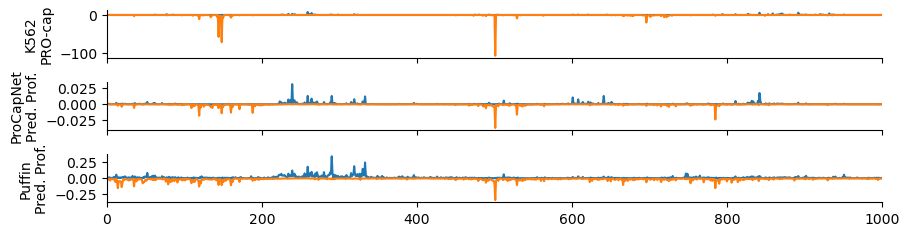

13942 ('chr19', 8193080, 8195194)
Read Count: 60.0


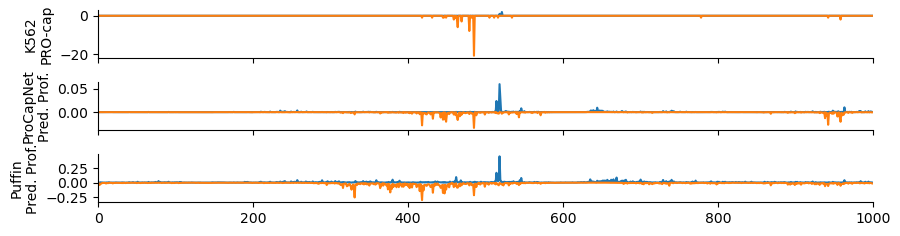

14111 ('chr19', 11765900, 11768014)
Read Count: 871.0


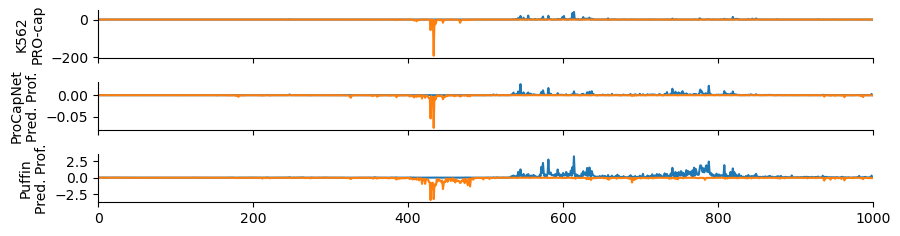

14192 ('chr19', 12995706, 12997820)
Read Count: 192.0


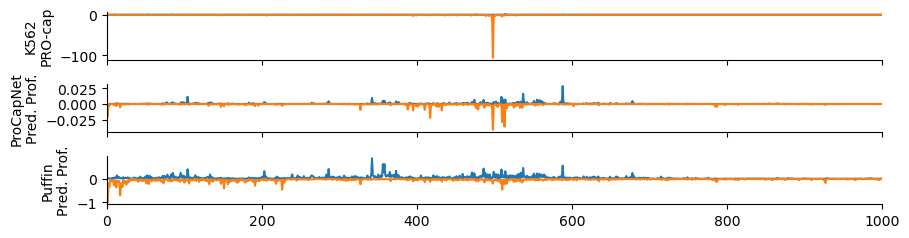

14273 ('chr19', 14431034, 14433148)
Read Count: 26.0


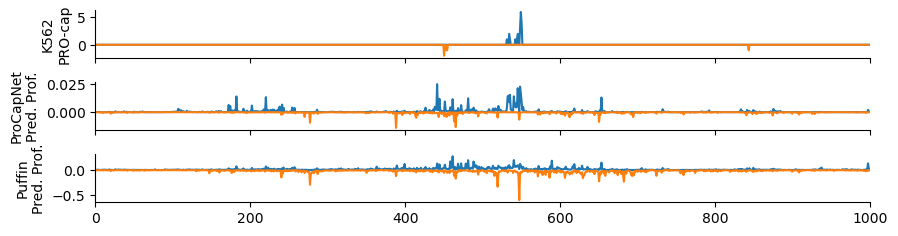

14845 ('chr19', 39501877, 39503991)
Read Count: 251.0


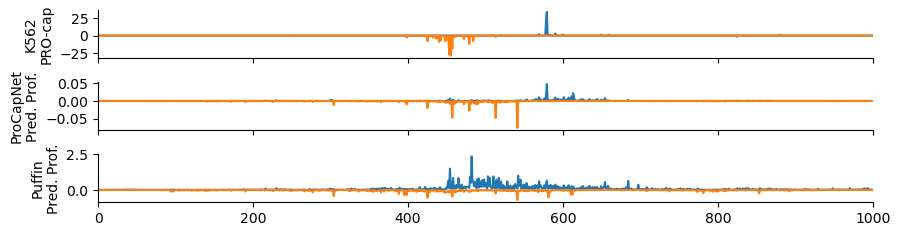

14868 ('chr19', 40419767, 40421881)
Read Count: 495.0


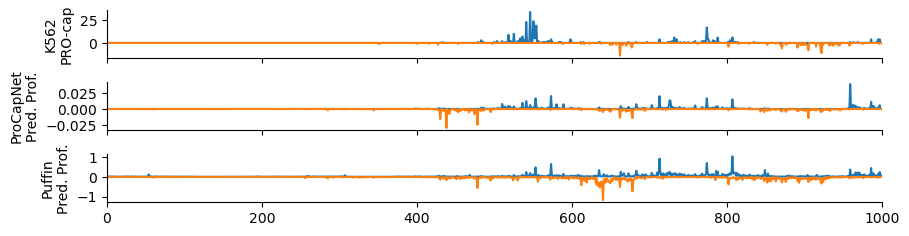

14918 ('chr19', 41192083, 41194197)
Read Count: 116.0


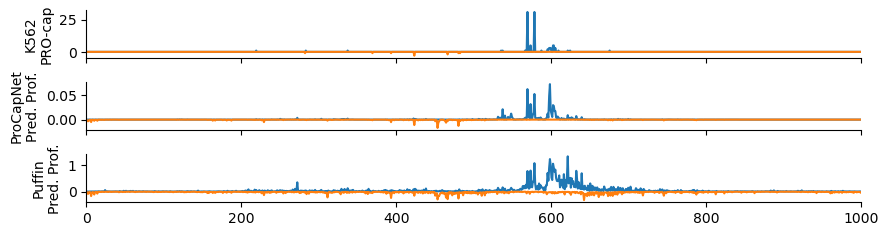

15017 ('chr19', 43826297, 43828411)
Read Count: 247.0


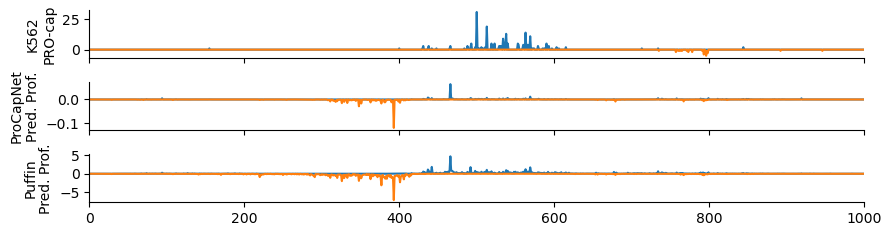

15359 ('chr19', 49486378, 49488492)
Read Count: 2053.0


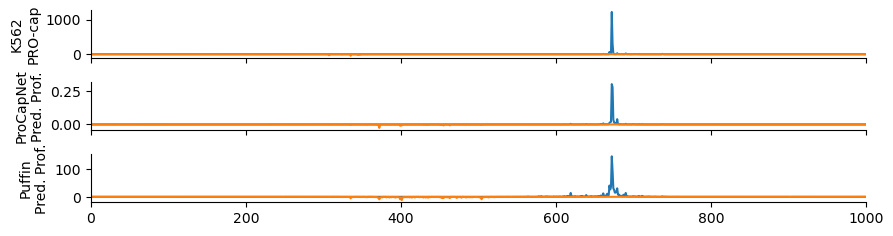

15488 ('chr19', 51459544, 51461658)
Read Count: 126.0


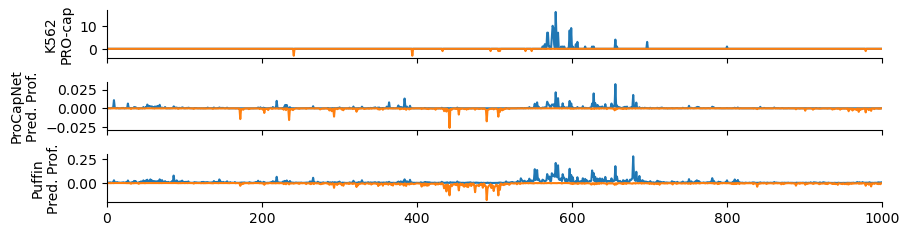

15523 ('chr19', 52007194, 52009308)
Read Count: 352.0


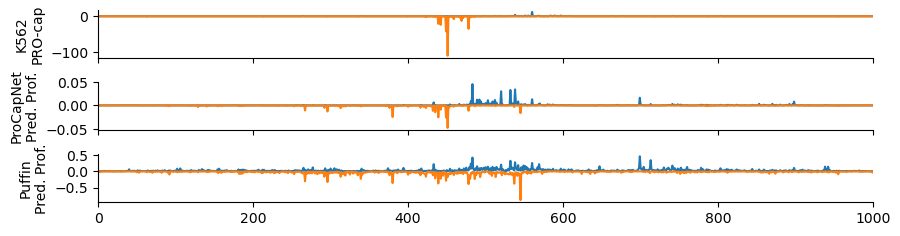

15581 ('chr19', 54136020, 54138134)
Read Count: 99.0


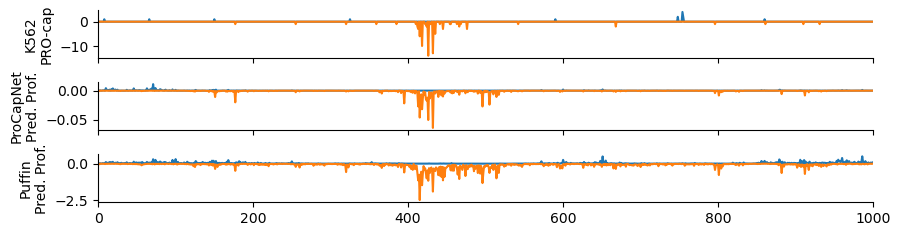

15919 ('chr2', 24075765, 24077879)
Read Count: 846.0


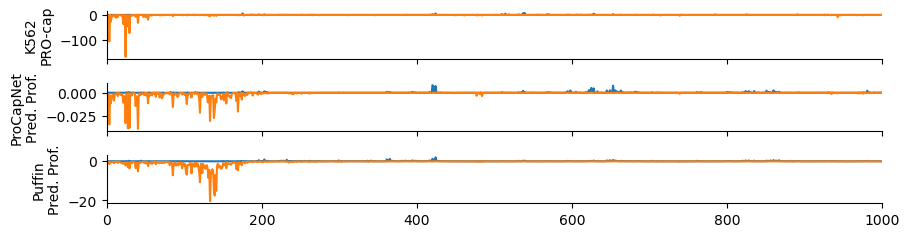

16092 ('chr2', 39778243, 39780357)
Read Count: 1472.0


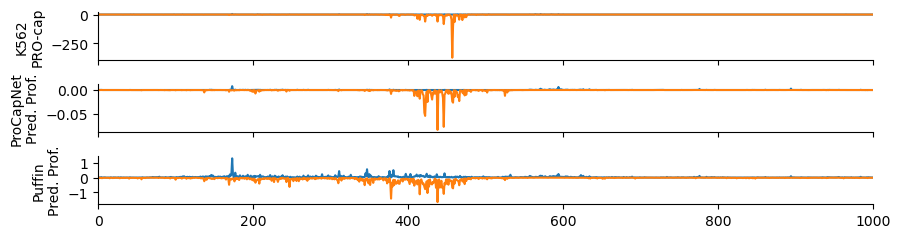

16310 ('chr2', 64143453, 64145567)
Read Count: 995.0


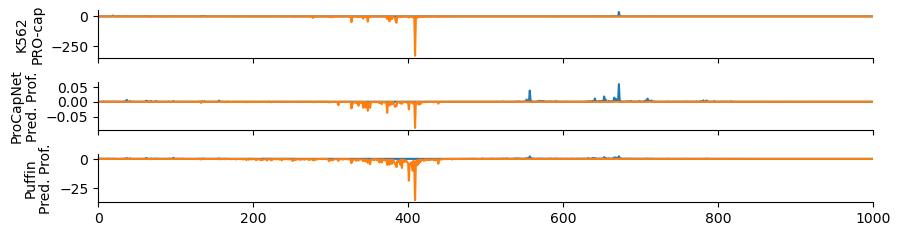

16417 ('chr2', 70135354, 70137468)
Read Count: 224.0


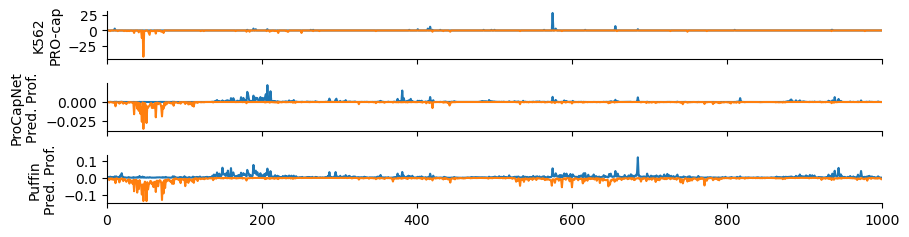

16531 ('chr2', 84887897, 84890011)
Read Count: 44.0


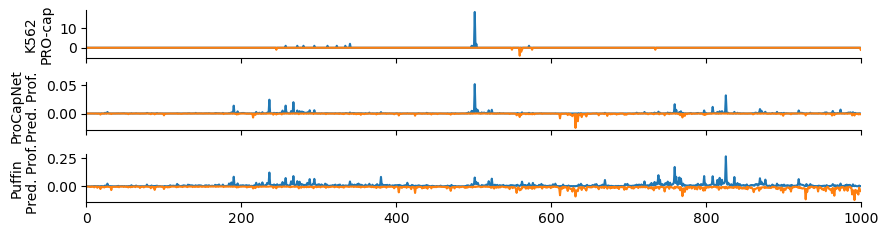

16969 ('chr2', 144581826, 144583940)
Read Count: 298.0


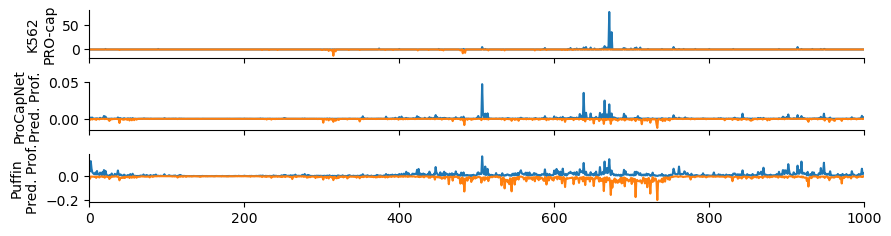

17035 ('chr2', 157875293, 157877407)
Read Count: 1394.0


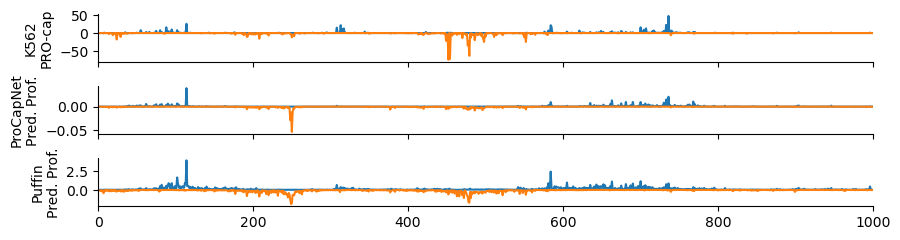

17218 ('chr2', 179263819, 179265933)
Read Count: 143.0


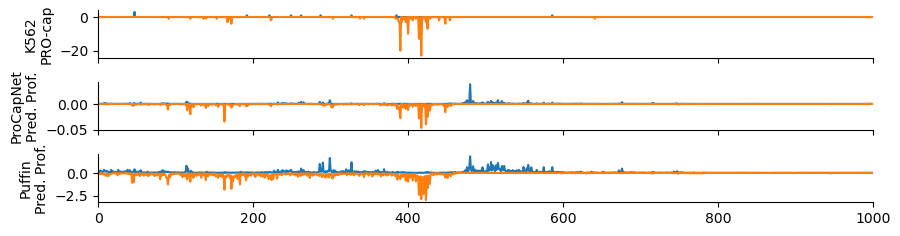

17416 ('chr2', 203871203, 203873317)
Read Count: 963.0


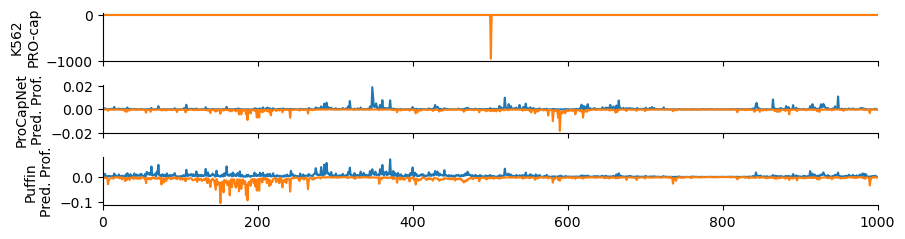

17448 ('chr2', 208500304, 208502418)
Read Count: 63.0


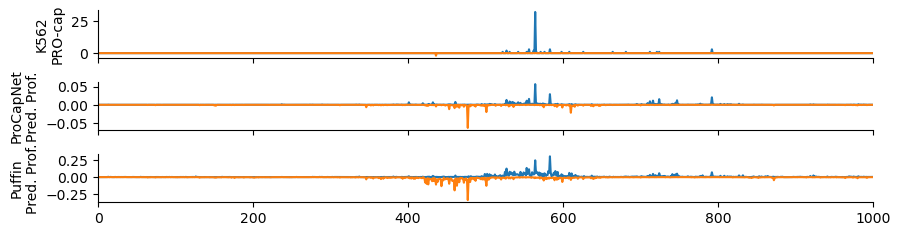

18365 ('chr20', 58650150, 58652264)
Read Count: 863.0


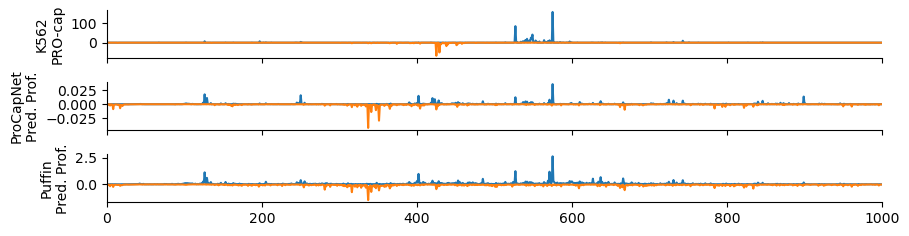

18599 ('chr21', 31731940, 31734054)
Read Count: 69.0


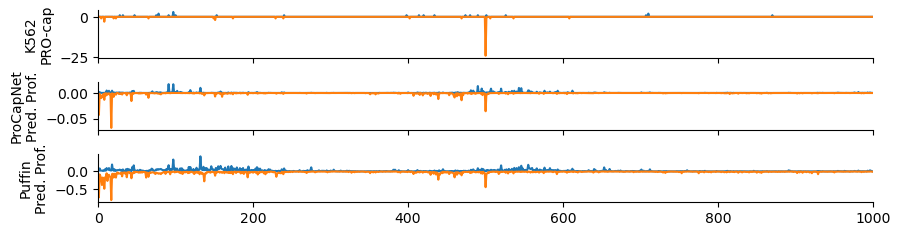

18618 ('chr21', 33323207, 33325321)
Read Count: 914.0


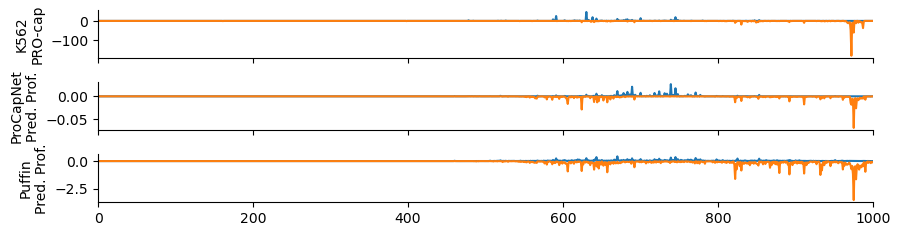

18769 ('chr21', 43883261, 43885375)
Read Count: 273.0


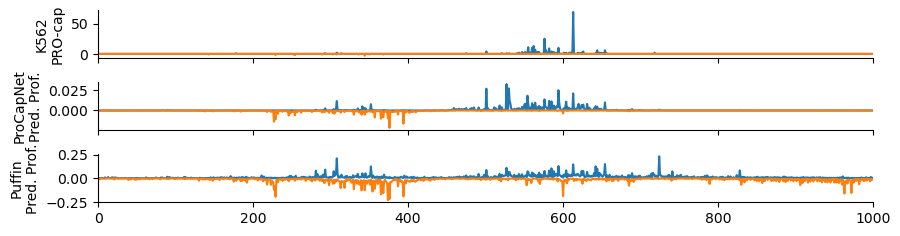

18854 ('chr22', 17157938, 17160052)
Read Count: 492.0


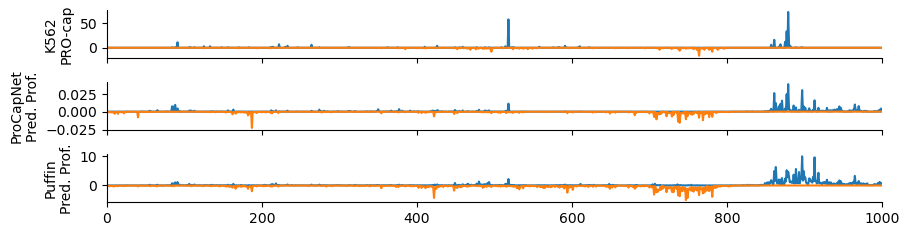

19027 ('chr22', 21640554, 21642668)
Read Count: 3413.0


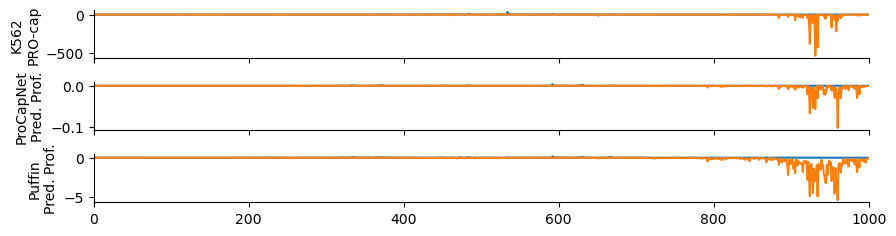

19080 ('chr22', 22551262, 22553376)
Read Count: 143.0


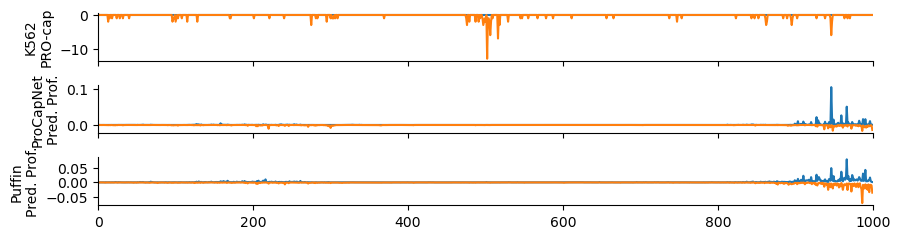

19136 ('chr22', 27668501, 27670615)
Read Count: 68.0


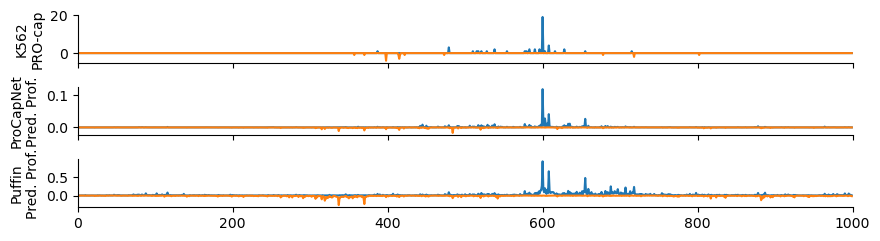

19138 ('chr22', 27725802, 27727916)
Read Count: 237.0


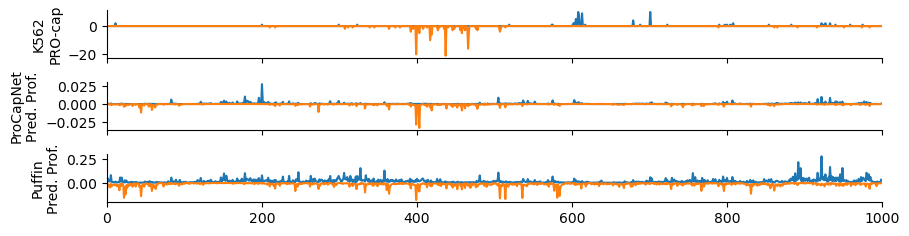

19306 ('chr22', 37656930, 37659044)
Read Count: 372.0


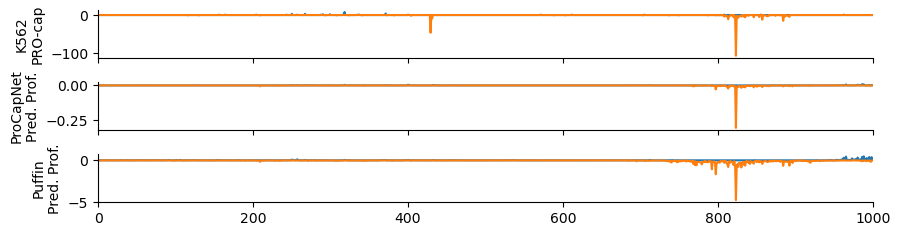

19540 ('chr22', 49656511, 49658625)
Read Count: 464.0


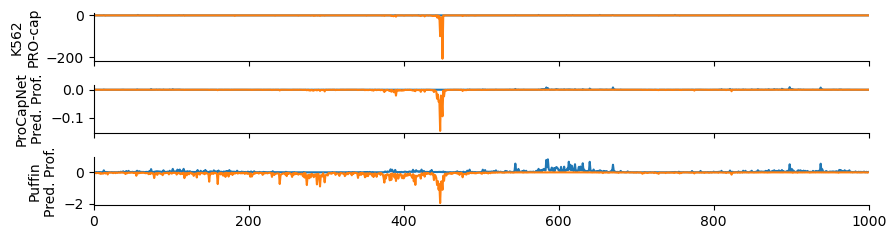

19583 ('chr22', 50525975, 50528089)
Read Count: 189.0


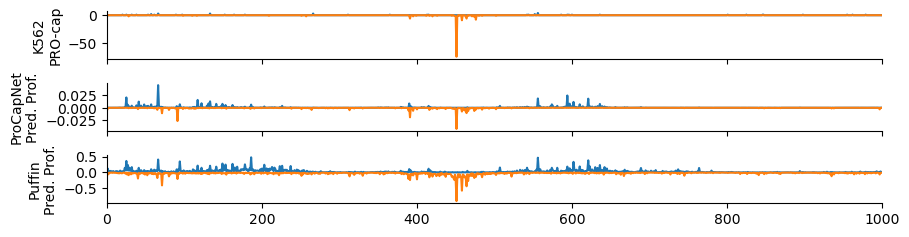

19738 ('chr3', 14124830, 14126944)
Read Count: 223.0


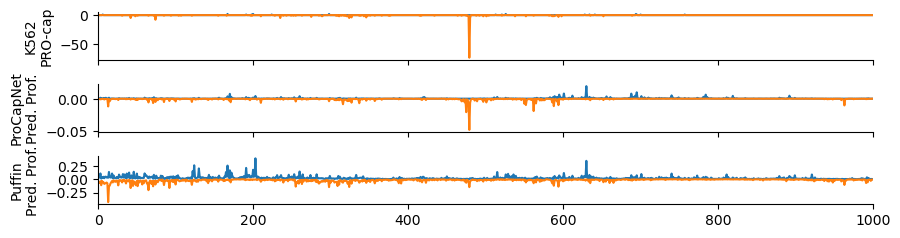

19751 ('chr3', 14401976, 14404090)
Read Count: 1394.0


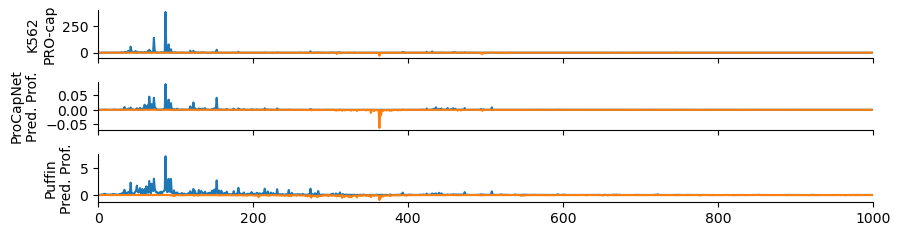

19839 ('chr3', 28347639, 28349753)
Read Count: 1125.0


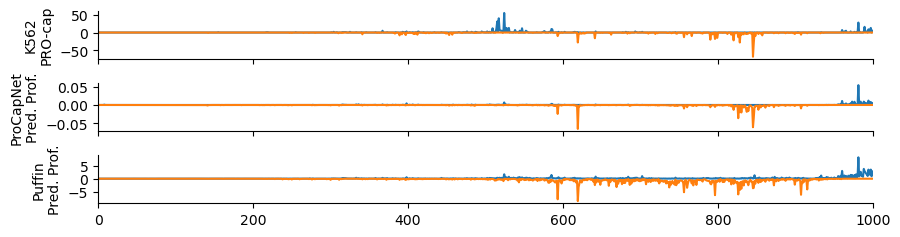

20062 ('chr3', 47474902, 47477016)
Read Count: 1291.0


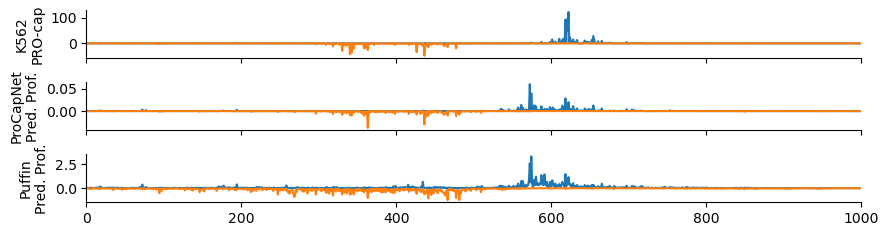

20096 ('chr3', 48662714, 48664828)
Read Count: 370.0


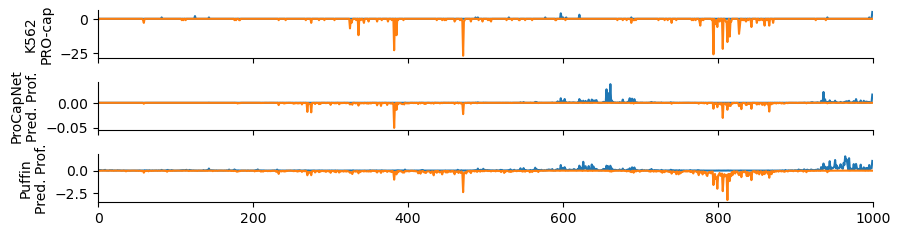

20218 ('chr3', 52408988, 52411102)
Read Count: 251.0


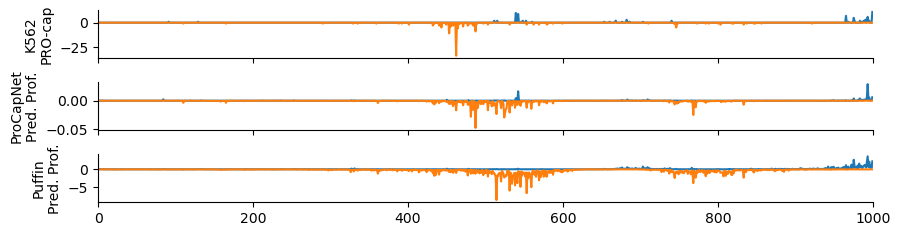

20264 ('chr3', 57754928, 57757042)
Read Count: 369.0


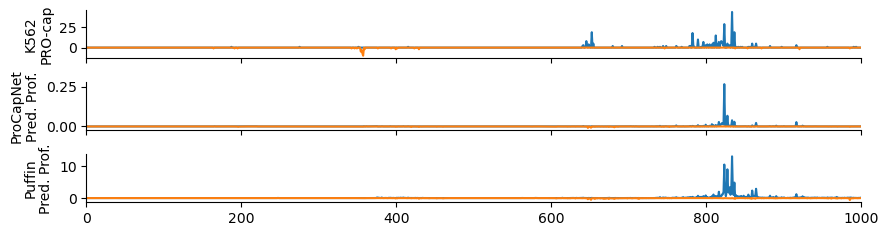

20558 ('chr3', 127589766, 127591880)
Read Count: 268.0


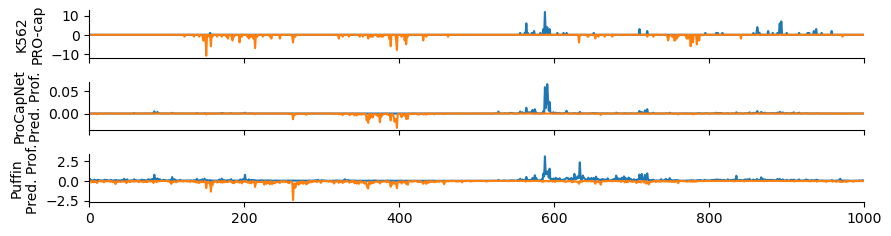

20817 ('chr3', 152268556, 152270670)
Read Count: 350.0


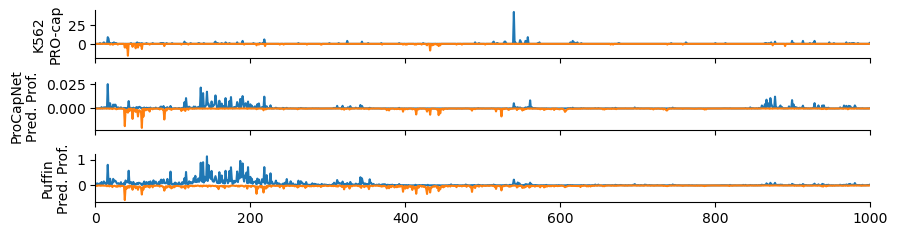

20938 ('chr3', 170036873, 170038987)
Read Count: 243.0


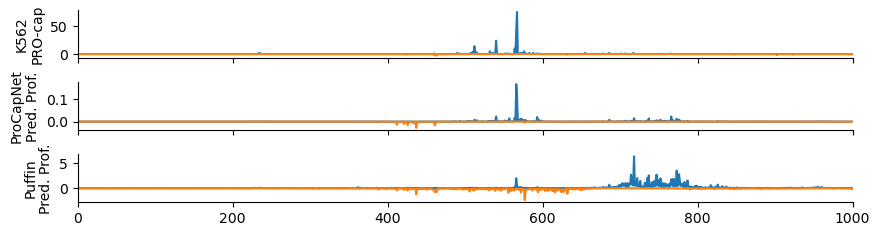

20955 ('chr3', 171469890, 171472004)
Read Count: 35.0


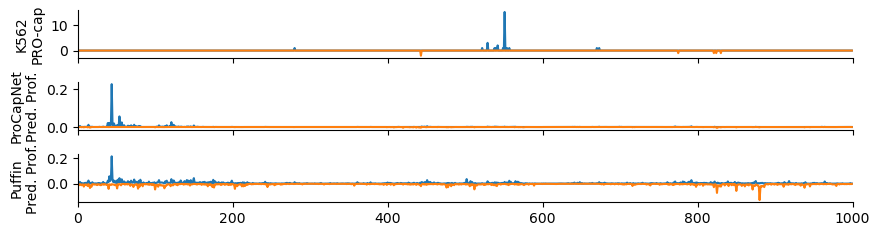

20994 ('chr3', 179275140, 179277254)
Read Count: 26.0


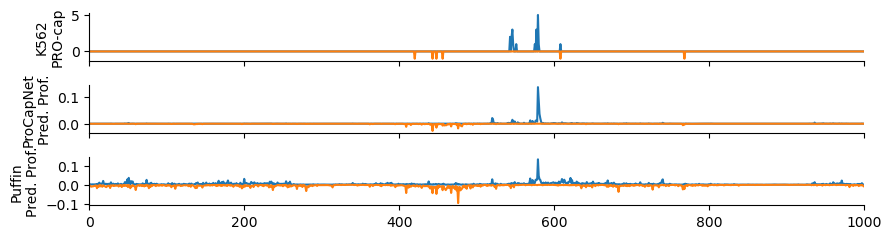

21141 ('chr3', 194165988, 194168102)
Read Count: 81.0


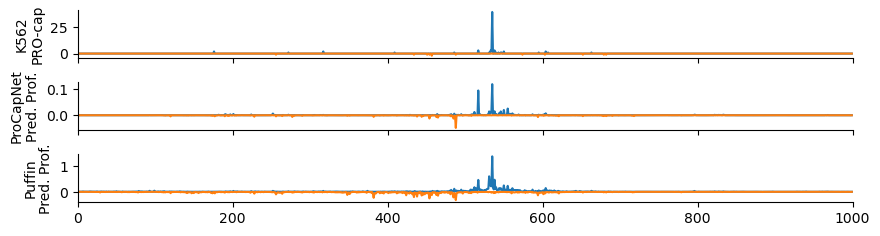

21166 ('chr3', 195270607, 195272721)
Read Count: 222.0


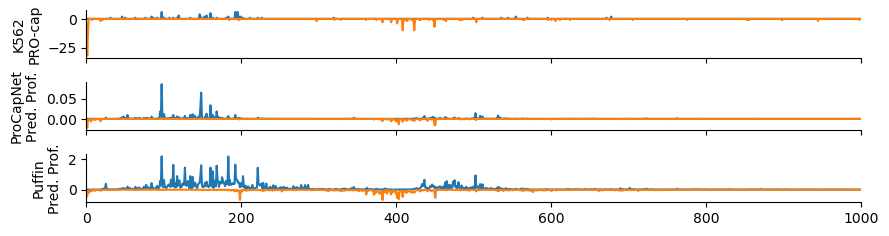

21236 ('chr3', 196968957, 196971071)
Read Count: 515.0


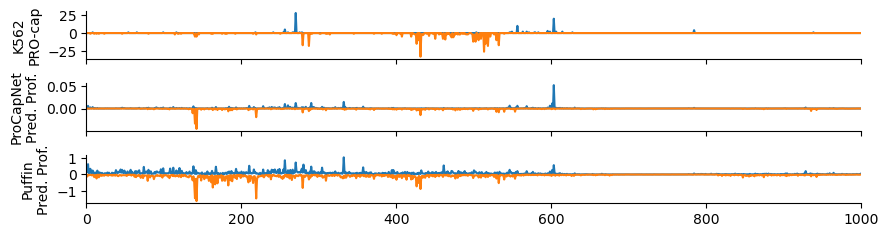

21247 ('chr3', 197455660, 197457774)
Read Count: 127.0


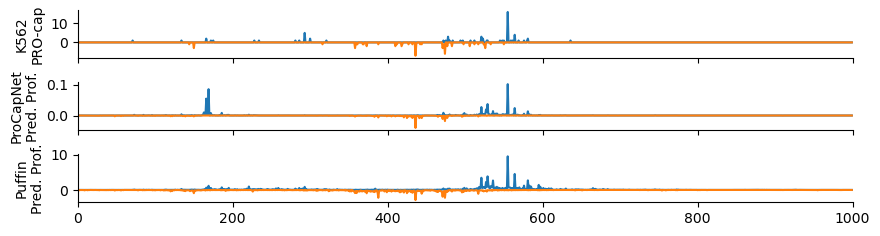

21286 ('chr4', 704633, 706747)
Read Count: 1067.0


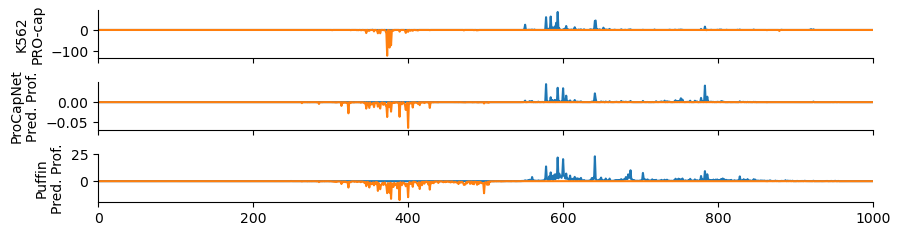

21417 ('chr4', 6986081, 6988195)
Read Count: 785.0


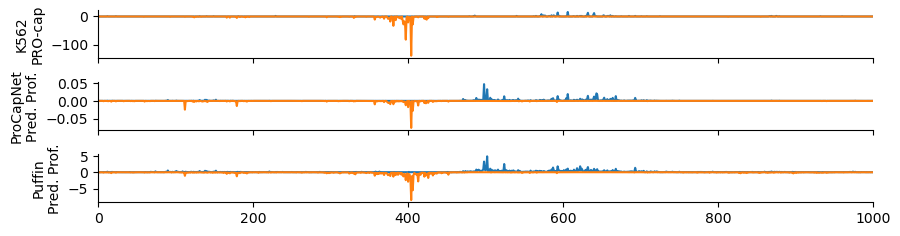

21460 ('chr4', 15003863, 15005977)
Read Count: 278.0


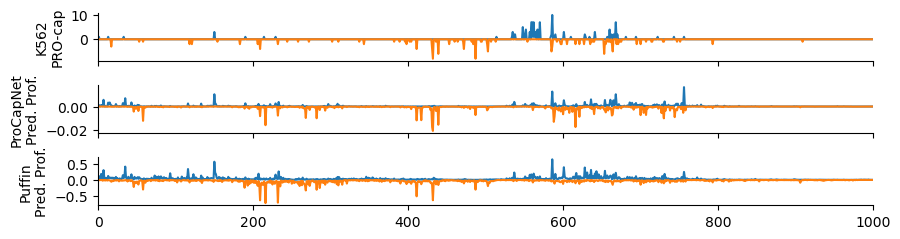

21487 ('chr4', 25860613, 25862727)
Read Count: 86.0


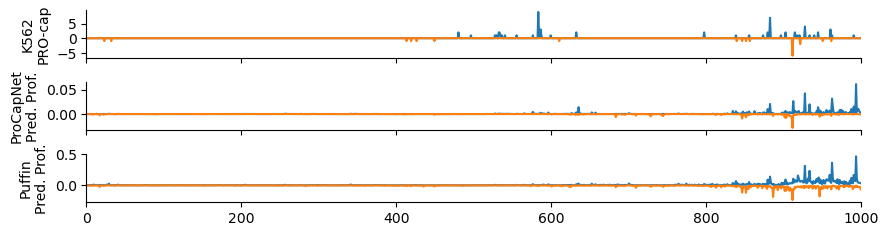

21582 ('chr4', 47462633, 47464747)
Read Count: 664.0


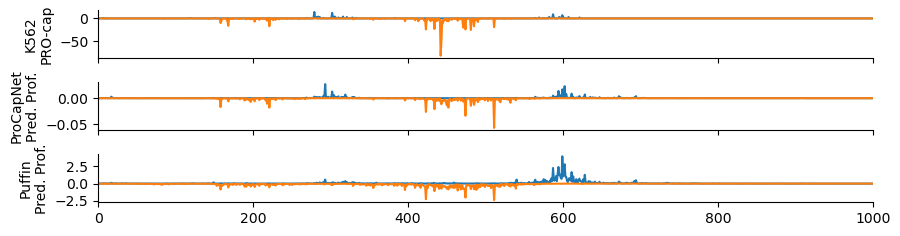

21701 ('chr4', 73703657, 73705771)
Read Count: 90.0


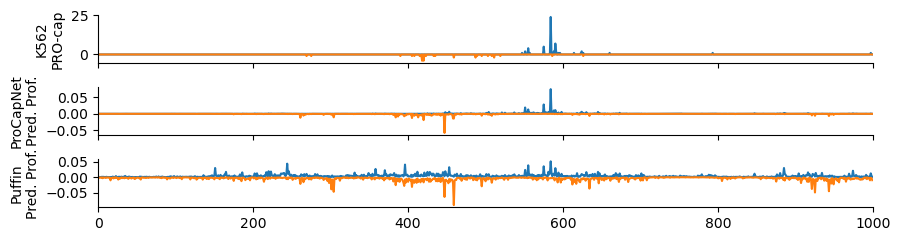

21746 ('chr4', 77155680, 77157794)
Read Count: 583.0


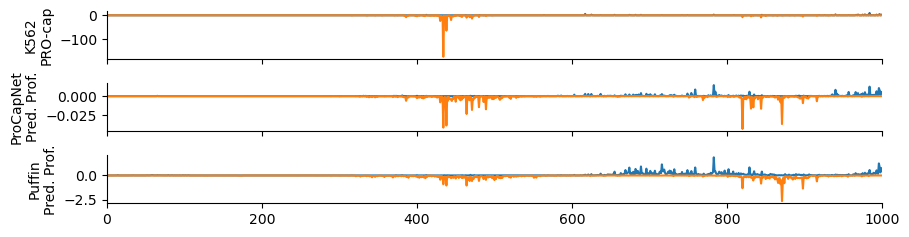

21879 ('chr4', 98142498, 98144612)
Read Count: 116.0


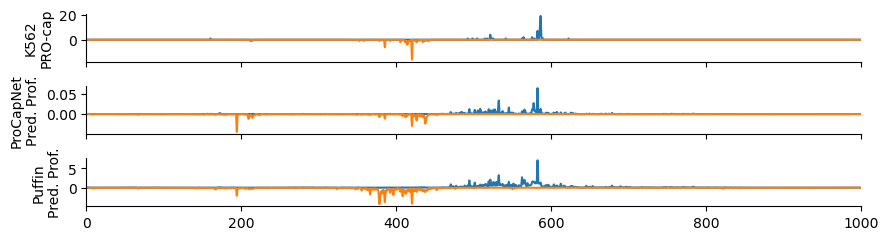

21959 ('chr4', 109433159, 109435273)
Read Count: 944.0


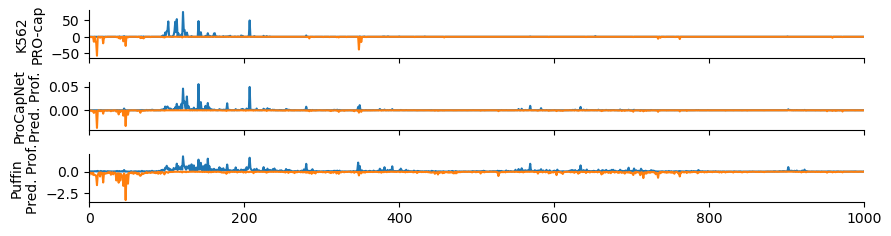

22017 ('chr4', 122748750, 122750864)
Read Count: 449.0


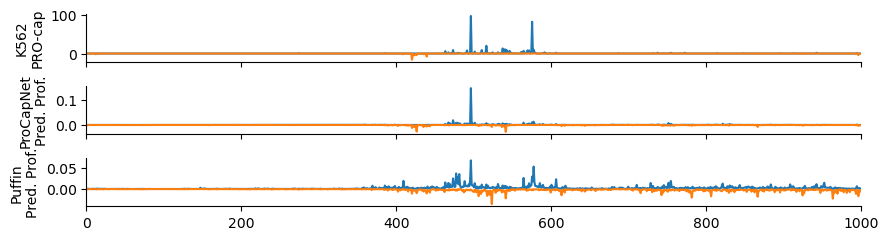

22377 ('chr5', 10248545, 10250659)
Read Count: 717.0


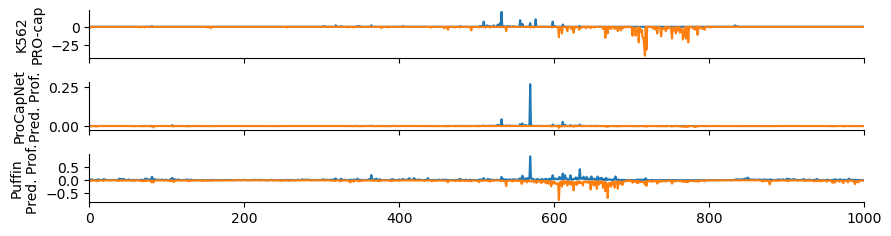

22455 ('chr5', 34914224, 34916338)
Read Count: 1910.0


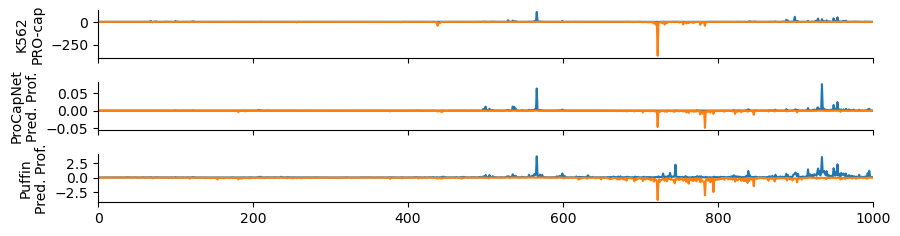

22890 ('chr5', 104451351, 104453465)
Read Count: 80.0


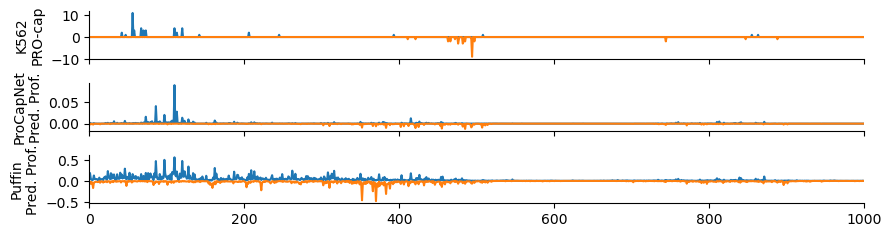

23157 ('chr5', 138574765, 138576879)
Read Count: 1123.0


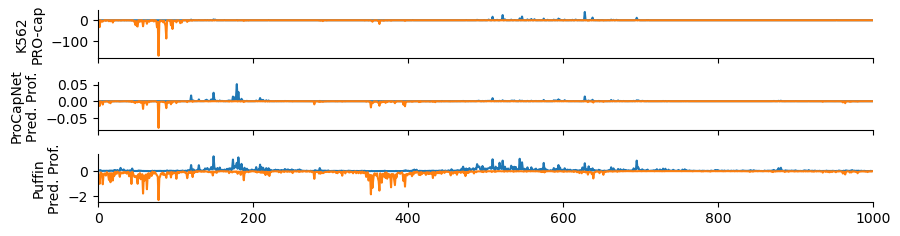

23230 ('chr5', 140690415, 140692529)
Read Count: 922.0


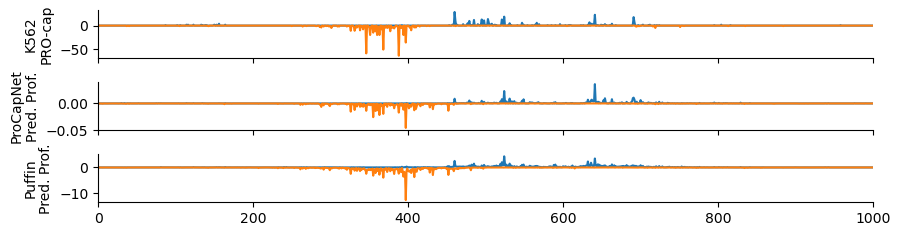

23264 ('chr5', 142088324, 142090438)
Read Count: 76.0


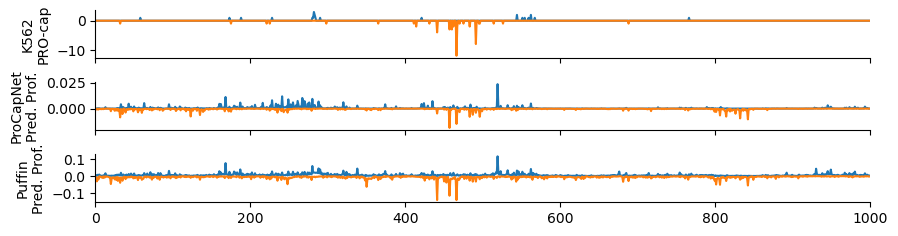

23274 ('chr5', 142363638, 142365752)
Read Count: 81.0


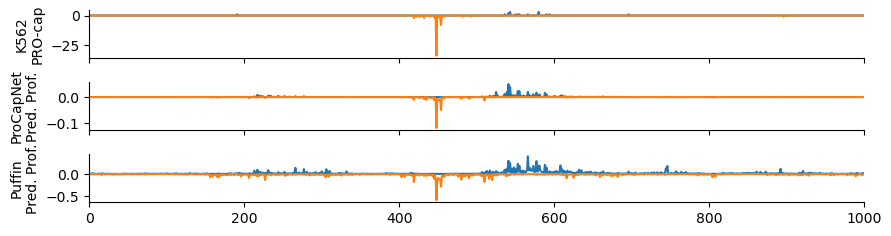

23368 ('chr5', 154037403, 154039517)
Read Count: 624.0


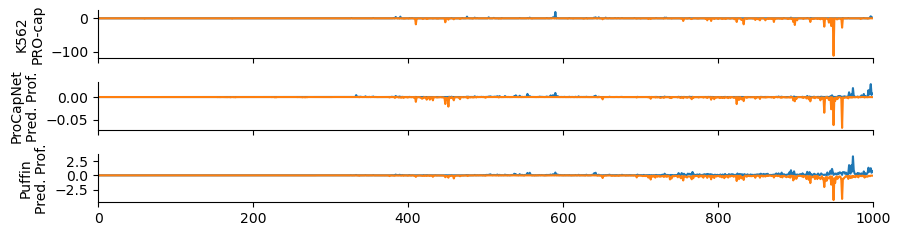

23407 ('chr5', 160118365, 160120479)
Read Count: 762.0


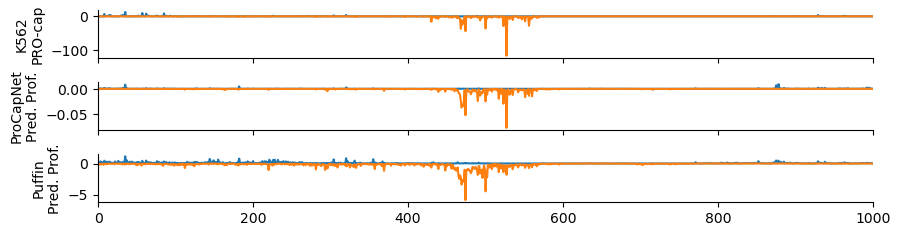

23452 ('chr5', 172005367, 172007481)
Read Count: 499.0


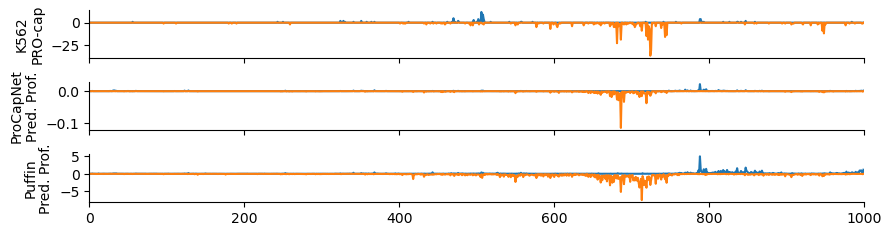

23583 ('chr5', 179549481, 179551595)
Read Count: 3288.0


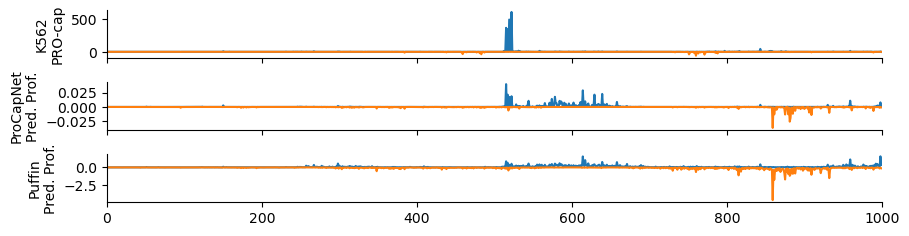

23586 ('chr5', 179611904, 179614018)
Read Count: 235.0


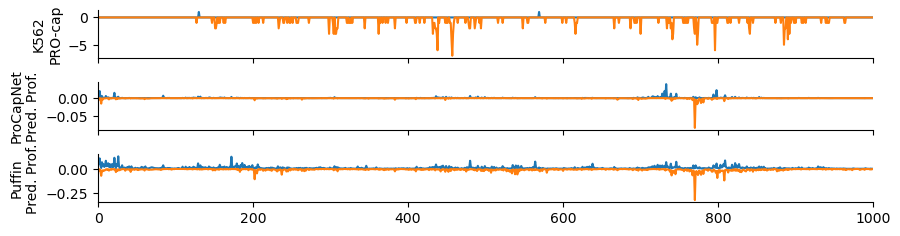

23656 ('chr5', 181243289, 181245403)
Read Count: 1438.0


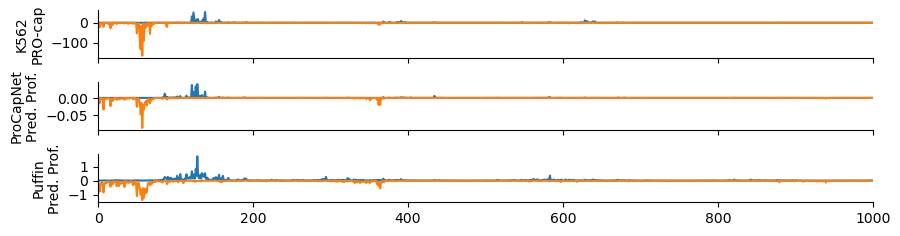

23869 ('chr6', 13813594, 13815708)
Read Count: 2950.0


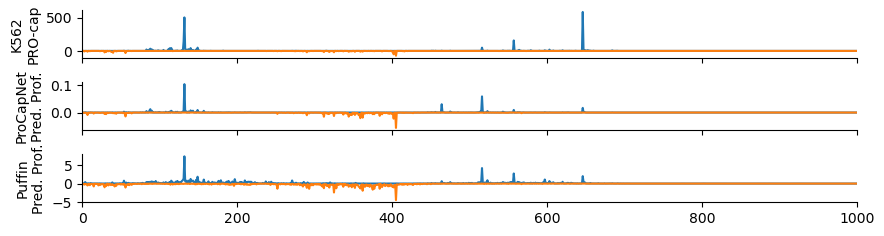

23971 ('chr6', 24719983, 24722097)
Read Count: 4641.0


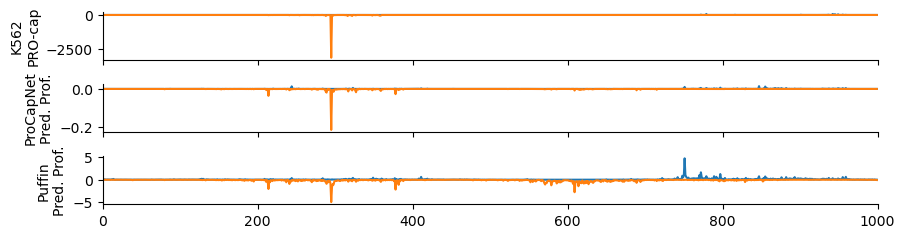

24081 ('chr6', 26598329, 26600443)
Read Count: 37.0


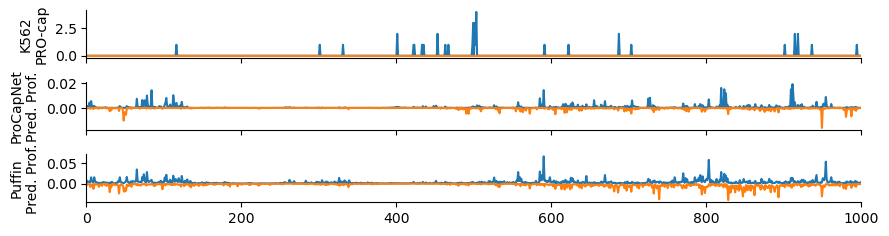

24121 ('chr6', 27236588, 27238702)
Read Count: 88.0


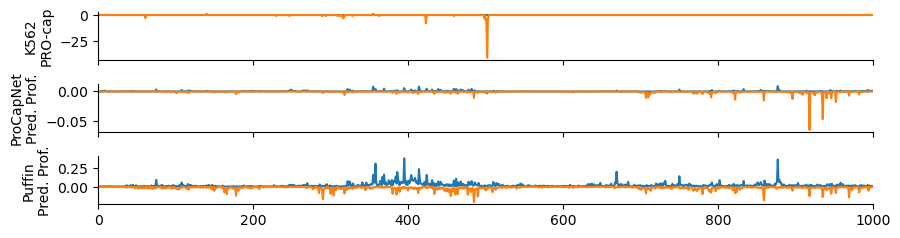

24287 ('chr6', 28862749, 28864863)
Read Count: 248.0


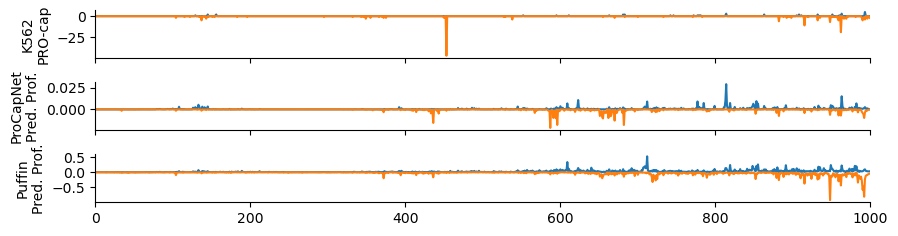

24299 ('chr6', 28897167, 28899281)
Read Count: 101.0


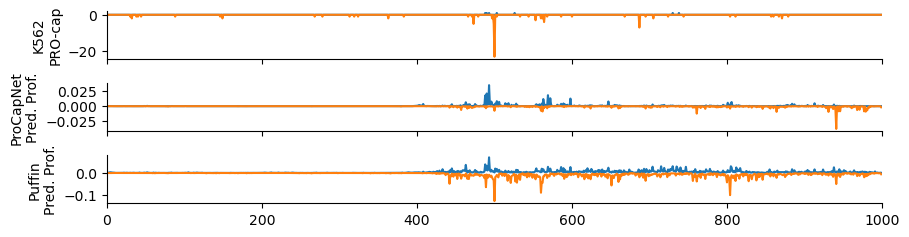

24520 ('chr6', 32254279, 32256393)
Read Count: 59.0


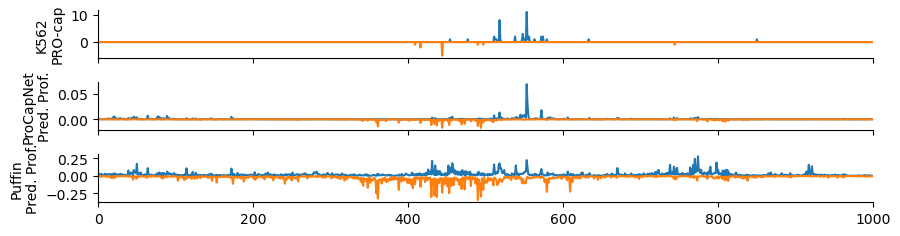

24695 ('chr6', 37082645, 37084759)
Read Count: 133.0


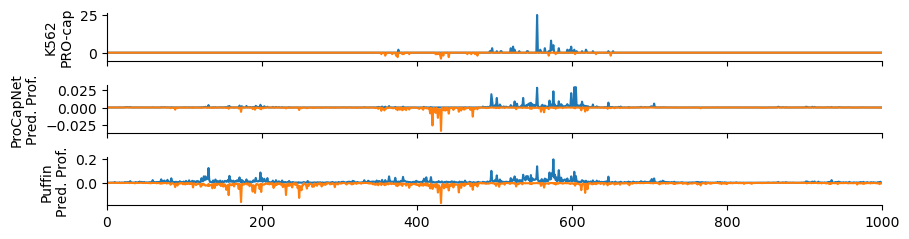

24812 ('chr6', 42978204, 42980318)
Read Count: 1673.0


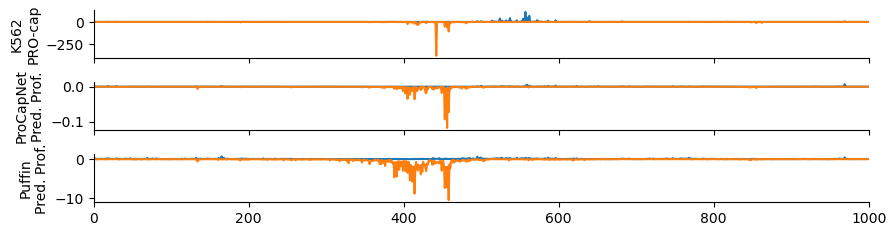

24833 ('chr6', 43368348, 43370462)
Read Count: 1186.0


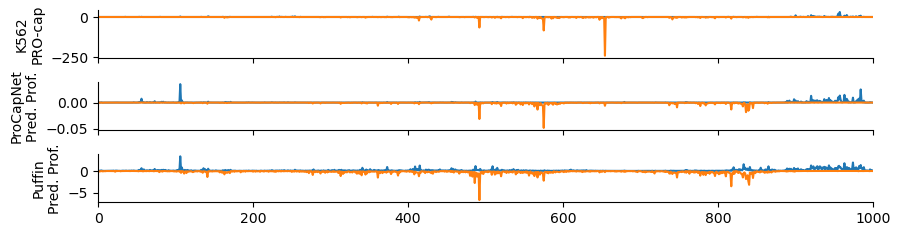

25469 ('chr6', 143059772, 143061886)
Read Count: 1013.0


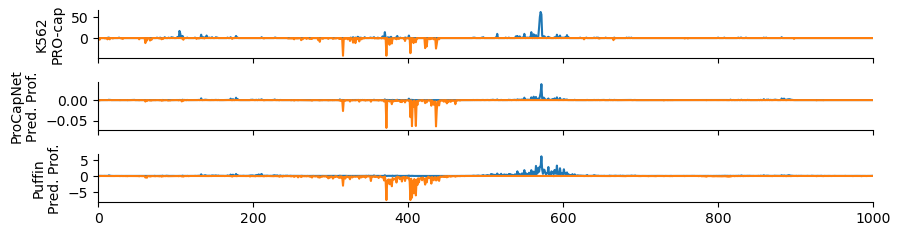

25523 ('chr6', 146886178, 146888292)
Read Count: 860.0


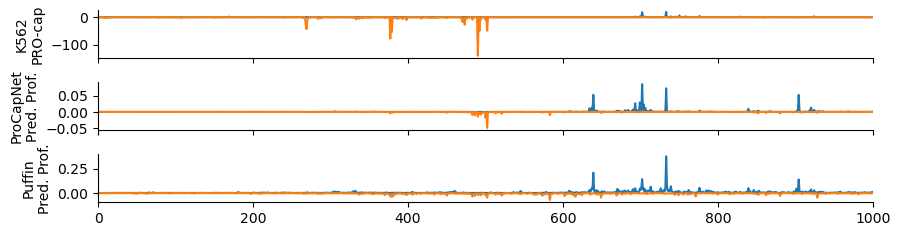

25637 ('chr6', 156686360, 156688474)
Read Count: 1324.0


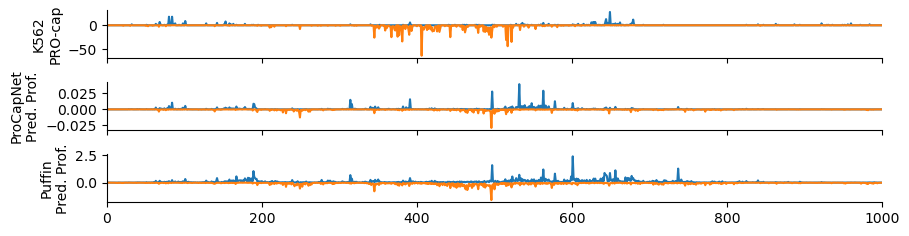

25642 ('chr6', 156777125, 156779239)
Read Count: 1075.0


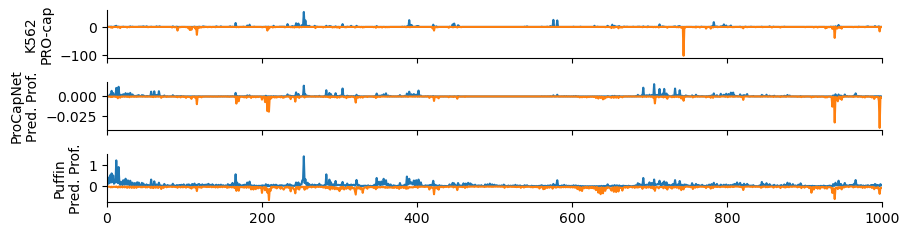

25773 ('chr7', 148509, 150623)
Read Count: 1367.0


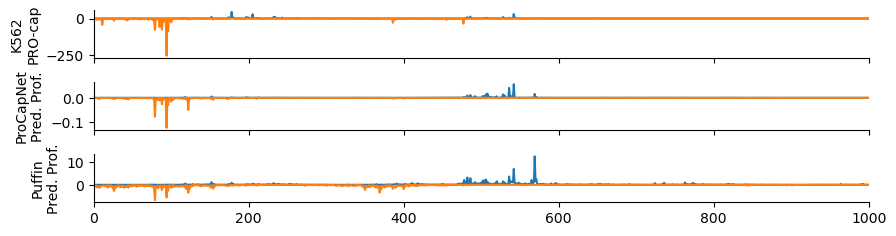

25890 ('chr7', 5512781, 5514895)
Read Count: 1383.0


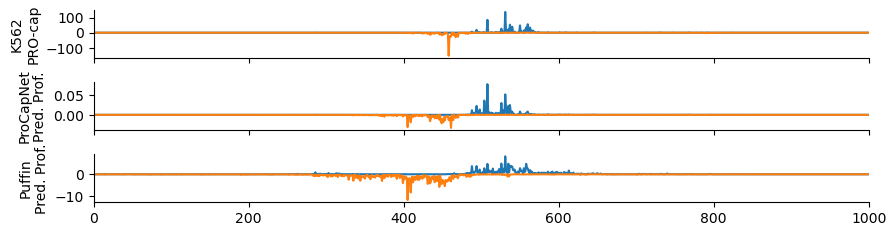

26028 ('chr7', 21426292, 21428406)
Read Count: 1367.0


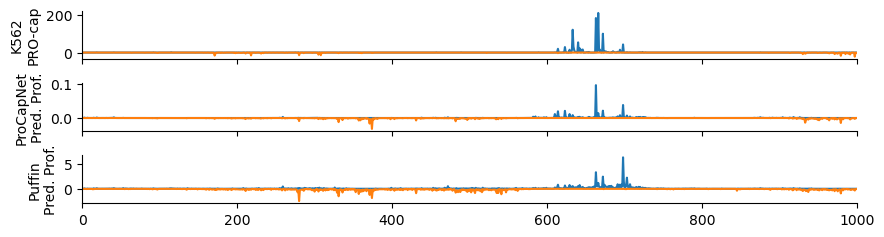

26053 ('chr7', 23013148, 23015262)
Read Count: 570.0


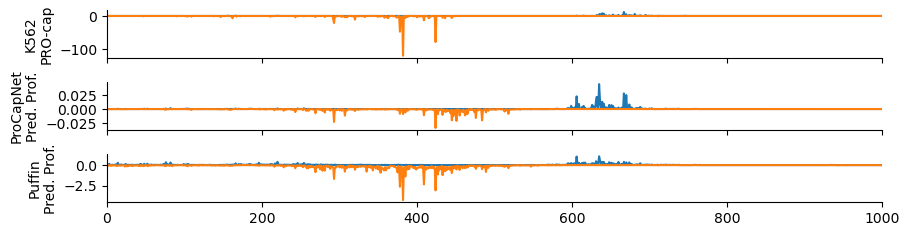

26277 ('chr7', 44920738, 44922852)
Read Count: 124.0


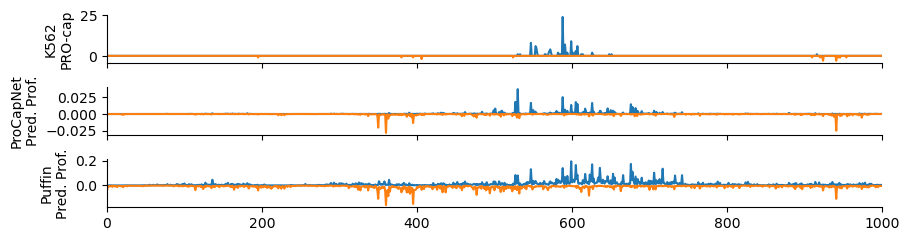

26496 ('chr7', 87151416, 87153530)
Read Count: 2731.0


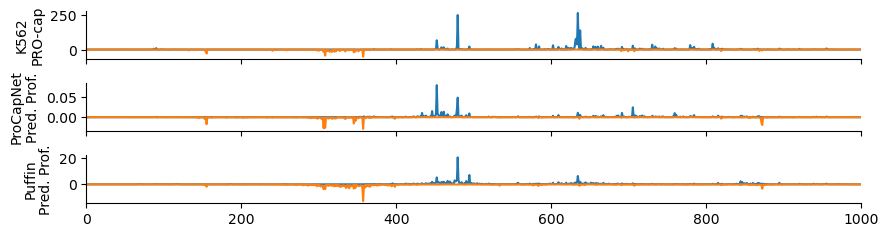

26867 ('chr7', 113117952, 113120066)
Read Count: 1653.0


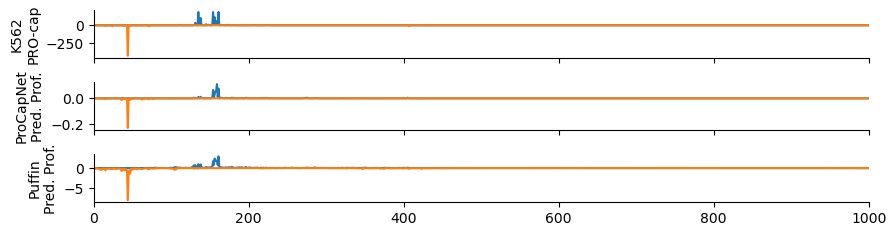

27004 ('chr7', 129438073, 129440187)
Read Count: 150.0


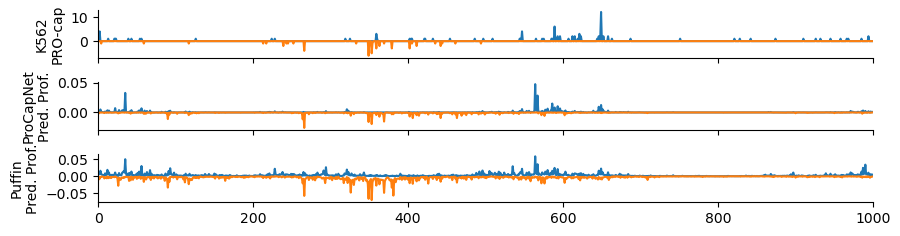

27153 ('chr7', 143900867, 143902981)
Read Count: 1155.0


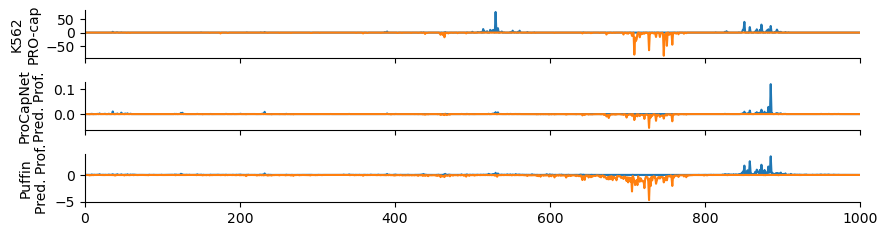

27244 ('chr7', 150973729, 150975843)
Read Count: 1002.0


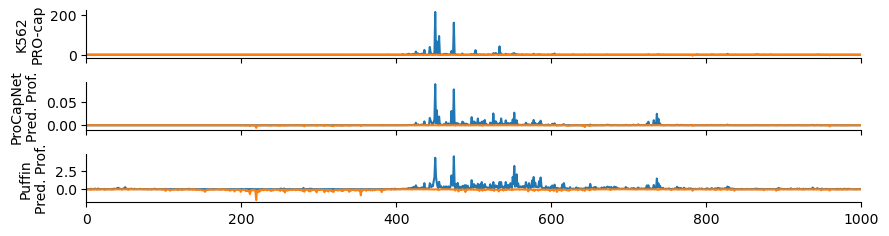

27316 ('chr7', 155204588, 155206702)
Read Count: 575.0


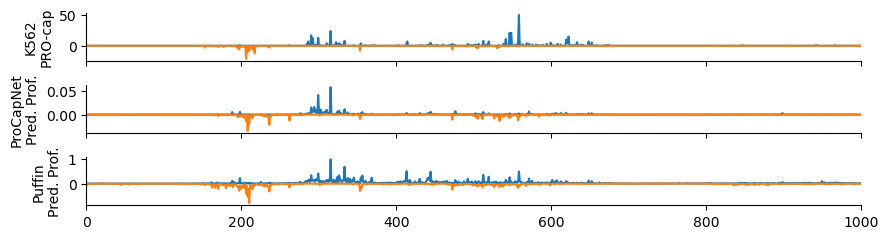

27426 ('chr8', 10776400, 10778514)
Read Count: 134.0


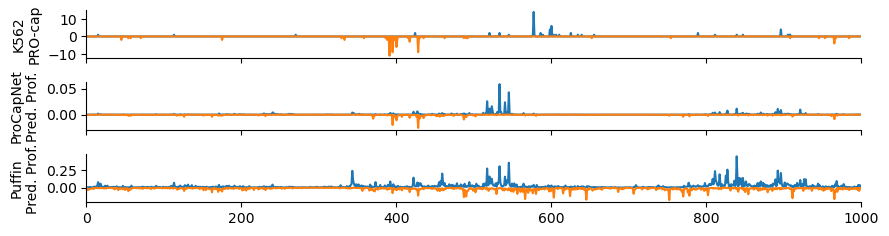

27669 ('chr8', 38385374, 38387488)
Read Count: 375.0


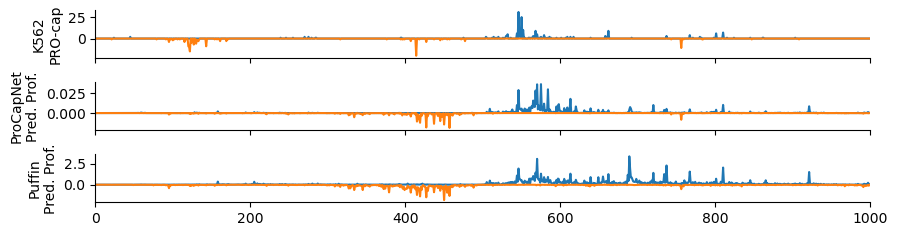

28135 ('chr8', 116873418, 116875532)
Read Count: 715.0


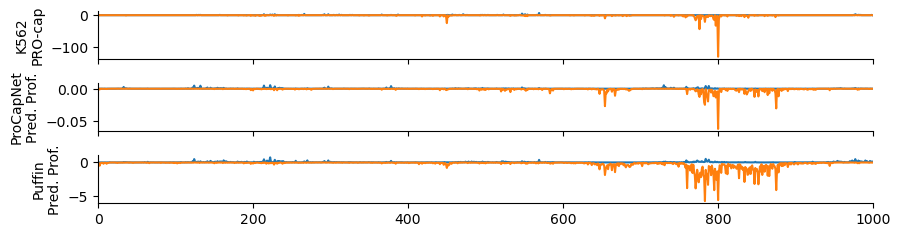

28143 ('chr8', 120443481, 120445595)
Read Count: 40.0


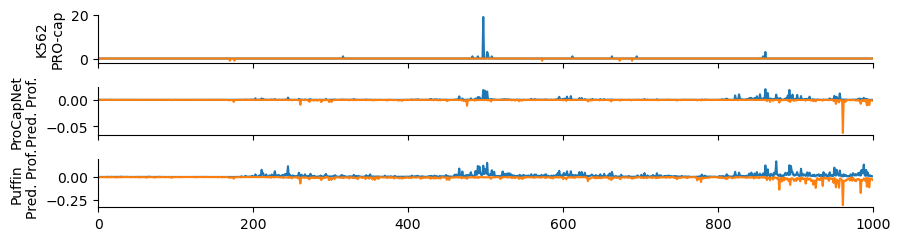

28705 ('chr9', 65674771, 65676885)
Read Count: 193.0


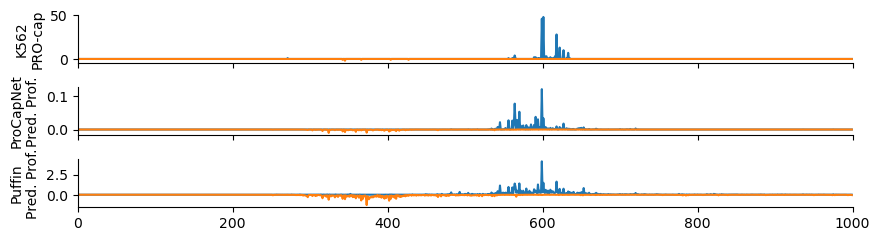

28748 ('chr9', 73131407, 73133521)
Read Count: 302.0


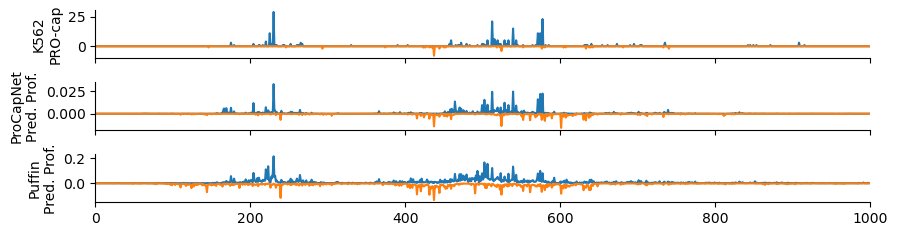

28990 ('chr9', 99092015, 99094129)
Read Count: 159.0


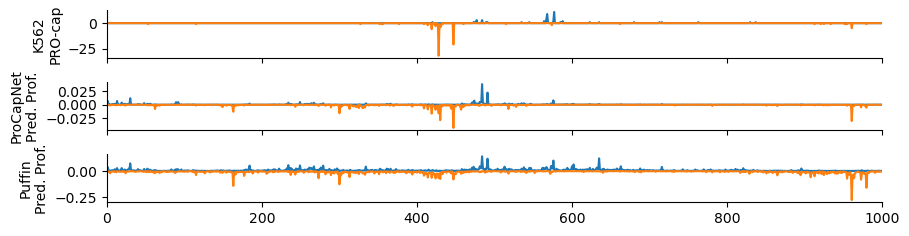

29054 ('chr9', 111482801, 111484915)
Read Count: 1326.0


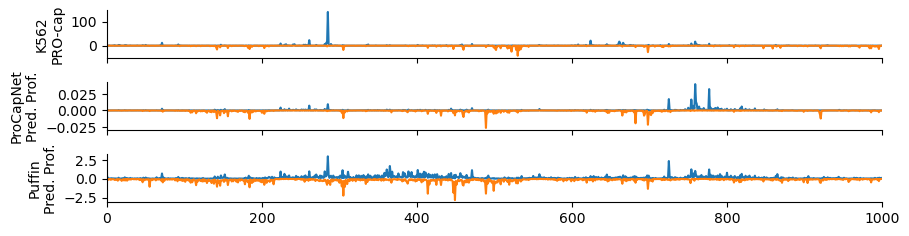

29389 ('chr9', 130680268, 130682382)
Read Count: 601.0


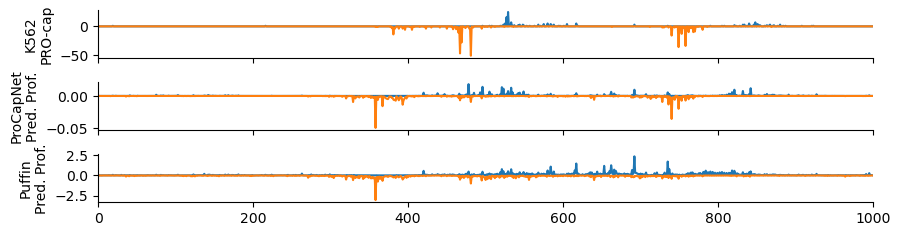

29438 ('chr9', 132240084, 132242198)
Read Count: 70.0


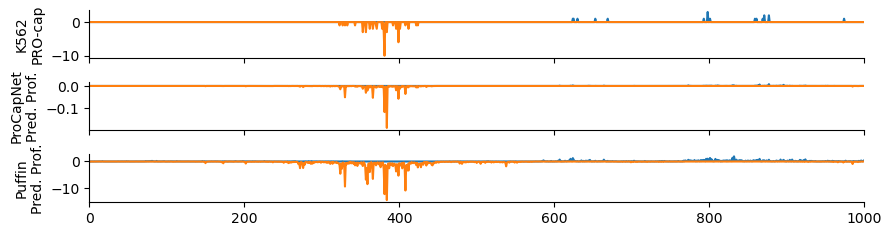

29644 ('chr9', 137577562, 137579676)
Read Count: 1636.0


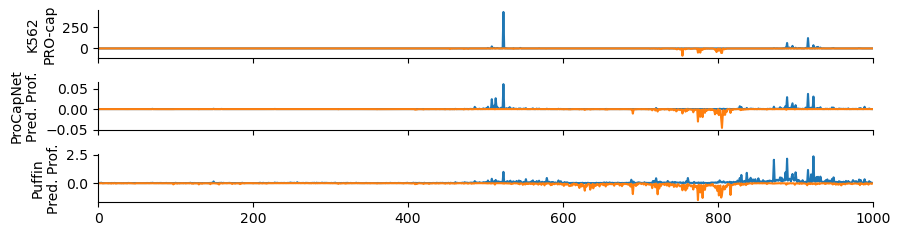

29680 ('chrX', 2252384, 2254498)
Read Count: 186.0


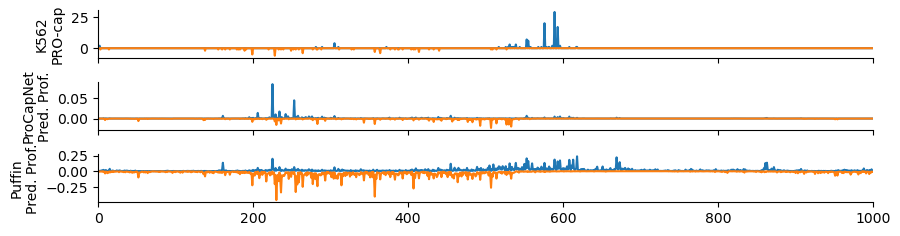

29730 ('chrX', 13012921, 13015035)
Read Count: 49.0


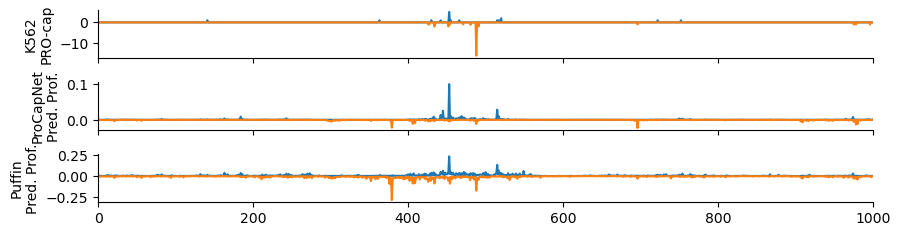

29916 ('chrX', 47482039, 47484153)
Read Count: 1010.0


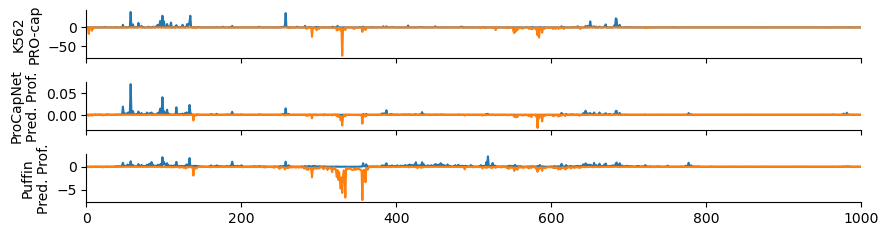

30083 ('chrX', 65999732, 66001846)
Read Count: 211.0


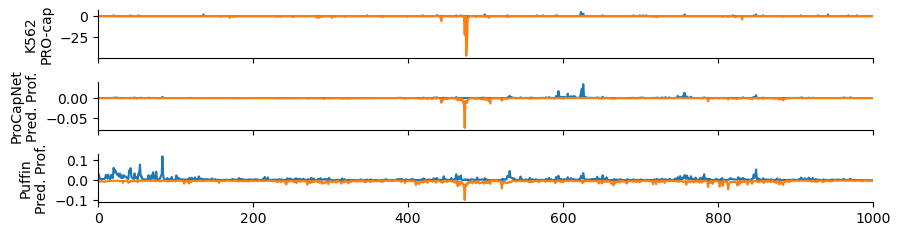

30403 ('chrX', 147910786, 147912900)
Read Count: 476.0


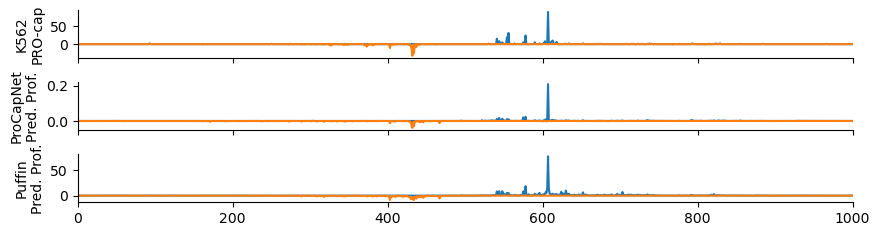

30472 ('chrX', 153971664, 153973778)
Read Count: 1170.0


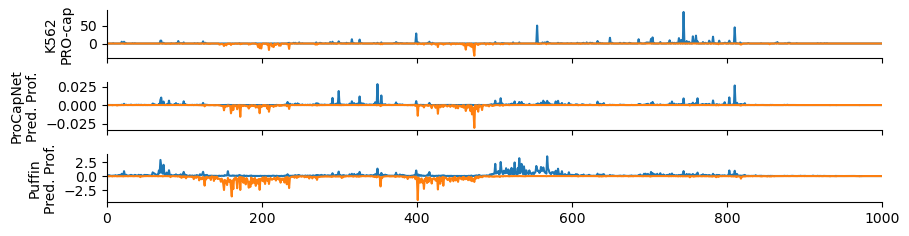

In [16]:
# Check Individual Examples at Random, Find Some To Do ISM On

for i in random_loci:
    # if not actually a lot of data in K562, ignore
    if np.sum(K562_true_profs[i]) < 20:
        continue
    
    print(i, coords[i])
    print("Read Count:", np.sum(K562_true_profs[i]))
    
    fig, axes = plt.subplots(3, figsize=(10,2.5), sharex=True)
    
    axes[0].plot(K562_true_profs[i][0])
    axes[0].plot(-1 * K562_true_profs[i][-1])
    axes[0].set_ylabel("K562\nPRO-cap")
    
    axes[1].plot(K562_procapnet_pred_profs[i][0])
    axes[1].plot(-1 * K562_procapnet_pred_profs[i][-1])
    axes[1].set_ylabel("ProCapNet\nPred. Prof.")
    
    axes[2].plot(K562_puffin_pred_profs[i][0])
    axes[2].plot(-1 * K562_puffin_pred_profs[i][-1])
    axes[2].set_ylabel("Puffin\nPred. Prof.")
    
    plt.xlim(0,1000)
    
    for ax in axes:
        ax.spines[["top", "right"]].set_visible(False)
    fig.subplots_adjust(hspace=0.5)
    plt.show()

In [20]:
# put indexes in this list to do ISM on next
# it turns out ISM takes forever so this list should be short
interesting_loci = [20938] # [1,9,29,33]

## ISM

In [ ]:
# tangermeme!!! from Jacob, https://github.com/jmschrei/tangermeme
from tangermeme.ism import saturation_mutagenesis
from tangermeme.utils import one_hot_encode as tangermeme_ohe


def load_sequence_at_locus(coord, genome_path):
    chrom, start, end = coord
    
    # load (forward strand) genomic sequence between start and end coords
    genome = read_fasta_fast(genome_path, include_chroms = [chrom])
    # seq is a string
    seq = genome[chrom][start:end]
    
    # one-hot encode the sequence string (returns numpy array)
    onehot_seq = one_hot_encode(seq).T
    
    # after transposing, onehot_seq is shape (4, end - start)
    return seq, onehot_seq


def trim_seq_to_puffin_len(seq, puffin_len=1650):
    # puffin has a smaller "in_window" than ProCapNet (1650 instead of 2114),
    # so this function trims the flanks of sequences to fit puffin's size
    
    assert type(seq) == str, type(seq)
    
    to_trim_total = len(seq) - puffin_len
    assert to_trim_total % 2 == 0, to_trim_total
    
    to_trim_side = to_trim_total // 2
    
    trimmed = seq[to_trim_side : - to_trim_side]
    
    assert len(trimmed) == puffin_len, len(trimmed)
    return trimmed

def puffin_predict(seq, puffin_model):
    if len(seq) > 1650:
        seq = trim_seq_to_puffin_len(seq)
        
    # using puffin's API for prediction
    raw_pred_df = puffin_model.predict(seq)
    
    # select for just the PRO-cap + and - strands from all outputs,
    # and need to exp - 1 because returned preds are log-e + 1
    pred = np.exp(np.array([np.array(raw_pred_df)[6],
                     np.array(raw_pred_df)[-1]]).astype(float)) - 1
    return pred

def reverse_ohe(seq_onehot):
    # turn a sequence that's been onehot-encoded back into a string
    assert len(seq_onehot.shape) == 2 and seq_onehot.shape[0] == 4, seq_onehot.shape
    seq_onehot = seq_onehot.T
    
    ohe_to_str = defaultdict(lambda : "N")
    ohe_to_str[(1,0,0,0)] = "A"
    ohe_to_str[(0,1,0,0)] = "C"
    ohe_to_str[(0,0,1,0)] = "G"
    ohe_to_str[(0,0,0,1)] = "T"
    
    seq_str = "".join([ohe_to_str[tuple([int(num) for num in base])] for base in seq_onehot])
    return seq_str


class PuffinWrapperProcap(torch.nn.Module):
    # tangermeme needs a model-wrapper to do ISM with -- this one is for puffin
    
    def __init__(self, model):
        super(PuffinWrapperProcap, self).__init__()
        self.model = model

    def logits_to_a_number_deepshappy(self, logits):
        # more complicated way of collapsing a profile prediction to just one scalar;
        # I tried this and the easier way below, results were qualitatively the same
        logits = torch.Tensor(logits).reshape(-1)
        mean_norm_logits = logits - torch.mean(logits, axis = -1, keepdims = True)
        softmax_probs = torch.nn.Softmax(dim=-1)(mean_norm_logits.detach())
        final = (mean_norm_logits * softmax_probs).sum(axis=-1)
        return final
    
    def logits_to_a_number(self, logits):
        # simplest way of collapsing a profile prediction to just one scalar
        pred = np.exp(logits)
        final = pred.sum()
        return final
        
    def forward_one_seq(self, seq):
        # take in one sequence and return a scalar, for ISM
        
        # Puffin's API needs strings, not one-hot encodings, so convert back
        if type(seq) != str:
            seq = seq.squeeze()
            assert len(seq.shape) == 2, seq.shape
            seq = reverse_ohe(seq)

        # get just the logits for the PRO-cap + and - strand preds
        all_preds = self.model.predict(seq)
        pred = np.array([np.array(all_preds)[6],
                         np.array(all_preds)[-1]]).astype(float)
        
        # convert logits to a single scalar
        return self.logits_to_a_number(pred)
        
    def forward(self, X):
        # doesn't need to be differentiable if we just do ISM
        
        # puffin's API does one sequence at a time, so...
        model_outputs = []
        for seq in X:
            model_outputs.append(self.forward_one_seq(seq))
        return torch.Tensor(np.array(model_outputs))

    
def get_puffin_ism(seq_onehot, puffin_model):
    assert seq_onehot.shape[-2] == 4, seq_onehot.shape
    seq_len = seq_onehot.shape[-1]

    wrapper = PuffinWrapperProcap(puffin_model)
    
    # the start and end here are hard-coded for the example I wanted to plot
    # (they let you just do ISM on the bases you're going to plot)
    X_attr = saturation_mutagenesis(wrapper, seq_onehot.squeeze()[None,...],
                                    start = seq_len//2 - 100, end = seq_len//2 + 250,
                                    device='cuda', verbose=True)
    return X_attr

In [57]:
class ProCapNetISMWrapper(torch.nn.Module):
    # tangermeme needs a model-wrapper to do ISM with -- this one is for ProCapNet
    
    def __init__(self, model):
        super(ProCapNetISMWrapper, self).__init__()
        self.model = model

    def logits_to_a_number_deepshappy(self, logits):
        # more complicated way of collapsing a profile prediction to just one scalar;
        # I tried this and the easier way below, results were qualitatively the same
        logits = torch.Tensor(logits).reshape(-1)
        mean_norm_logits = logits - torch.mean(logits, axis = -1, keepdims = True)
        softmax_probs = torch.nn.Softmax(dim=-1)(mean_norm_logits.detach())
        final = (mean_norm_logits * softmax_probs).sum(axis=-1)
        return final
    
    def logits_to_a_number(self, logits):
        # simplest way of collapsing a profile prediction to just one scalar
        pred = np.exp(logits)
        final = pred.sum()
        return final
        
    def forward_one_seq(self, seq):
        # make a model prediction, collapse to one number
        pred_prof = self.model(seq[None,...])[0].cpu().numpy()
        return self.logits_to_a_number(pred_prof)
        
    def forward(self, X):
        # make model predictions + collapse to 1 number per example
        model_outputs = [self.forward_one_seq(seq) for seq in X]
        return torch.Tensor(np.array(model_outputs))


def get_procapnet_ism(seq_onehot, model):
    assert seq_onehot.shape[-2] == 4, seq_onehot.shape
    seq_len = seq_onehot.shape[-1]

    wrapper = ProCapNetISMWrapper(model)
    
    # the start and end here are hard-coded for the example I wanted to plot
    # (they let you just do ISM on the bases you're going to plot)
    
    X_attr = saturation_mutagenesis(wrapper, seq_onehot.squeeze()[None,...],
                                    start = seq_len//2 - 100, end = seq_len//2 + 250,
                                    device='cuda', verbose=True)
    return X_attr

In [58]:
# run ISM, both models, on each locus chosen

ism_results = defaultdict(lambda : dict())
for locus_i in interesting_loci:
    _, seq_onehot = load_sequence_at_locus(coords[locus_i], genome_path)
    seq_onehot = torch.Tensor(seq_onehot)
    
    ism_results["puffin"][locus_i] = get_puffin_ism(seq_onehot, puffin).squeeze()
    ism_results["procapnet"][locus_i] = get_procapnet_ism(seq_onehot, procapnet).squeeze()

Loading genome sequence from /mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.fasta


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.26it/s]


## Plot Locus With ISM From Both Models

('chr3', 170036873, 170038987)
Puffin vs. ProCapNet at the $\it{GPR160}$ Promoter, chr3:170037860-170038180


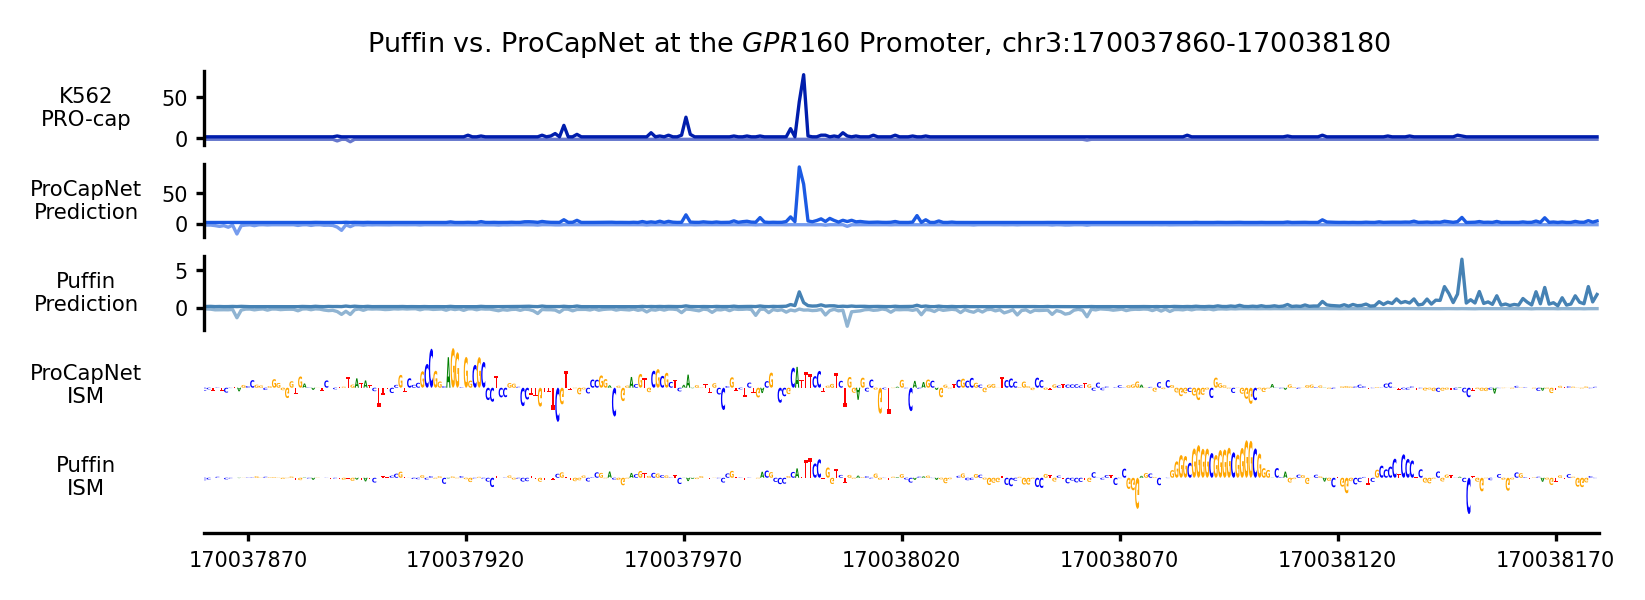

In [69]:
def plot_prof_on_ax(profile, ax, zoom_start, zoom_end,
                    color = "#001DAC", alphas = [1, 0.6],
                    linewidth=0.8, x_axis_buffer=0):
    
    # the + 0.5 is so the profiles are right on top of the bases of the scores
    x_range = np.arange(0, zoom_end -zoom_start) + 0.5
    
    # when both strands have data at 0, they'll plot on top of each other.
    # this offset is the minimum needed to uniformly add to the plotting
    # of both strands so that when the lines are at 0, they're both still visible
    offset = np.max(np.abs(profile[:, zoom_start:zoom_end])) * 0.02
    
    # plot positive strand
    ax.plot(x_range, profile[0, zoom_start:zoom_end] + offset,
            alpha = alphas[0], c = color, linewidth=linewidth)
    # plot negative strand
    ax.plot(x_range, -1 * profile[1, zoom_start:zoom_end] - offset,
            alpha = alphas[1], c = color, linewidth=linewidth)
    

def plot_motif_on_ax(array, ax):
    assert len(array.shape) == 2 and array.shape[-1] == 4, array.shape
    # reformat pwm to what logomaker expects
    df = pd.DataFrame(array, columns=['A', 'C', 'G', 'T'])
    df.index.name = 'pos'

    # plot motif ("baseline_width=0" removes the y=0 line)
    crp_logo = logomaker.Logo(df, ax=ax, font_name='Arial Rounded', baseline_width=0)
    
    # fix appearance to be less terrible
    crp_logo.style_spines(visible=False)
    ax.set_ylim(min(df.sum(axis=1).min(), 0), df.sum(axis=1).max())
    ax.set_xticks([])
    ax.set_yticks([])
    
    return crp_logo


def plot_locus(locus_i, start = out_window//2 - 100, stop = out_window//2 + 250,
               save_path = None):
    print(coords[locus_i])
    chrom, genomic_start, genomic_end = coords[locus_i]
    
    
    plot_params = {"xtick.labelsize": 8, "ytick.labelsize": 8}
    plt.rcParams.update(plot_params)
    axis_fontsize = 5.1
    axis_labelpad = 18
    axis_index = 0
    
    
    height_ratios = [100,100,100,100,100, 1]
    
    
    fig = plt.figure(figsize=(6, 0.4 * 5), dpi=300)
    gs = fig.add_gridspec(5 + 1, height_ratios = height_ratios, hspace=0.3)
    axes = gs.subplots()
    
    plot_prof_on_ax(K562_true_profs[locus_i], axes[0], start, stop,
                    color = "#001DAC")

    axes[0].set_ylabel("K562\nPRO-cap", fontsize=axis_fontsize,
                       labelpad=axis_labelpad, rotation=0,
                       verticalalignment = "center")
    
    
    plot_prof_on_ax(K562_procapnet_pred_profs[locus_i] * np.exp(K562_procapnet_pred_logcounts[locus_i]),
                    axes[1], start, stop,
                    color = "#1B5AE3")

    axes[1].set_ylabel("ProCapNet\nPrediction", fontsize=axis_fontsize,
                       labelpad=axis_labelpad, rotation=0,
                       verticalalignment = "center")
    
    plot_prof_on_ax(K562_puffin_pred_profs[locus_i], axes[2], start, stop,
                    color = "steelblue")

    axes[2].set_ylabel("Puffin\nPrediction", fontsize=axis_fontsize,
                       labelpad=axis_labelpad, rotation=0,
                       verticalalignment = "center")
    
    
    plot_motif_on_ax(ism_results["procapnet"][locus_i].T, axes[3])
    axes[3].set_ylabel("ProCapNet\nISM", fontsize=axis_fontsize,
                       labelpad=axis_labelpad, rotation=0,
                       verticalalignment = "center")
    
    plot_motif_on_ax(ism_results["puffin"][locus_i].T, axes[4])
    axes[4].set_ylabel("Puffin\nISM", fontsize=axis_fontsize,
                       labelpad=axis_labelpad, rotation=0,
                       verticalalignment = "center")
    
    
    # the zooming-into-bases-I-wanted-to-plot I did with the ISM parameters was close,
    # but not exact, so this parameter is just me cropping a few more bases off the left
    # side of the plot to zoom in on the interesting region better
    extra_by_eye_start_offset = 30 # like for aesthetics only
    
    xticks = np.arange(0, stop - start + 1, 50) - 10   
    
    for ax_i, ax in enumerate(axes):
        ax.spines[["top", "right"]].set_visible(False)
        
        if ax_i < len(axes) - 1:
            ax.set_xticks([])
            ax.spines[["bottom"]].set_visible(False)
        else:
            ax.set_xticks(xticks, xticks + start + genomic_start + (in_window // 2 - out_window // 2))
            ax.tick_params("x", length=2, pad=2, labelsize=5)
            ax.set_yticks([])
            
        ax.tick_params("y", length=2, pad=2, labelsize=5)
        
        ax.set_xlim(0 + extra_by_eye_start_offset, stop - start)
    
    title = "Puffin vs. ProCapNet at the " + r'$\it{GPR160}$ Promoter, ' + chrom + ":"
    title += str(genomic_start + in_window//2 + (start - out_window//2) + extra_by_eye_start_offset) + "-"
    title += str(genomic_start + in_window//2 + (stop - out_window//2))
    fig.suptitle(title, y = 0.95, fontsize=6.5, horizontalalignment='center')
    
    print(title)
    fig.align_ylabels()
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0.05, dpi = 300)
    
    plt.show()

    
plot_locus(interesting_loci[0], save_path = figures_dir + "puffin_vs_pcn_example.png")